<a href="https://colab.research.google.com/github/madhumitafilos/Collab/blob/main/Feature_Engineering_NoLeakage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Feature Engineering**

Performance metrics : Throughout this workbook, Mean Absolute Error(MAE), Mean Squared Error(MSE), Root Mean Square Error(RMSE) and R-Squared has been used to determine the Performance Metrics.Since the submissions are being assessed based on MAE, I have used MAE as the primary performance metrics to finalise the model.

Outliers : Outliers were determined using the Zscore. A common threshold of a Z-score of 3 or -3 was set. Then the 95th and 99th quantile for the feature was determined. The count of data exceeding these 95th, 99th quantile was also determined for each feature.If the Zscore was more than 3 Standard deviations and beyond the 99th quantile then those records were clipped to the 99th quantile value.

Correlation : There was good correlations between active_power and wind_speed_avg, rotor_angular_velocity, weather_wind_speed.We can see it in the Heatmap  in the section .

Important features : Corelation between features and KBest algorithm was used to determine the most important features for predicting the active_power.

Normalization : Few of the selected features when represented on a histogram showed that data was skewed for the selected features. So Box Cox transformation was used to transform few features and reduce the skewness of the data distribution and thus augmenting the data in order to have more accurate results.

Limitations of the dataset : It was observed that the generation of active power changed across years from 2013 till 2016. It was not uniform enough and so the predictions using a linear model didnt yield good results. There were a lot of data with negative active power which meant that instead of generating power, the wind turbine was consuming power from the grid. Few features weather_temp, weather_wind_speed and weather_wind_angle were collected from meteorological sources and these are not actual power generation data. So there was a bit of unreliability on this data.

Dimensionality reduction - Using KBest algorithm , the top 8 features were extracted from the dataset. wind_speed_avg was used instead of wind_speed1 and wind_speed2 as the selected feature since it is the average of both these speeds.

Regularization - Lasso and Ridge regression output was compared against linear regression output on a chart and they all yielded almost the same results. So regularization was not required.

Hyperparameters tuning - Grid search cv was used to tune the hyperparameters. This selected hyperparameter was used to fit the dataset.

Overfitting -

Cross validation - Cross validation was used to avoid information leakage from training dataset to test and validation sets.

Ensemble of models - Bagging?Stacking?Boosting?

Information leakage - Information leakage from test/validation set to the training set during training leading to an incorrect estimate of model performance on new data was observed. To avoid this leakage,






**1.Import required libraries**

In [9]:
# numerical library:
import numpy as np

# data manipulation library:
import pandas as pd

# to split data to training and validation dataset
from sklearn.model_selection import train_test_split

# linear regression model
from sklearn.linear_model import LinearRegression

#Metrics
from sklearn import metrics

#Creation of Heatmap
import matplotlib.pyplot as plt
import seaborn as sns

#Random forest
from sklearn.ensemble import RandomForestRegressor

**2.Read/Extract data**

In [10]:
wind_DS = pd.read_csv('/content/drive/MyDrive/training_data.csv')
wind_DS.head()

,active_power,timestamp,pitch_angle,reactive_power,nacelle_angle,nacelle_temp,wind_speed1,wind_speed2,wind_speed_avg,wind_angle,...,outdoor_temp,rotor_angular_velocity,rotor_bearing_temp,weather_temp,pressure,humidity,weather_wind_speed,weather_wind_angle,rain_1h,snow_1h
0,801.22998,2013-01-01 00:00:00,-1.0,67.559998,286.00000,20.129999,7.52,7.76,7.64,286.19000,...,5.44,16.950001,26.049999,5.39,1011.0,75.0,5.66,180.0,0.0,0.0
1,943.16998,2013-01-01 00:10:00,-1.0,70.260002,286.00000,21.420000,8.18,8.45,8.31,288.32999,...,5.74,17.139999,26.100000,5.39,1011.0,75.0,5.66,180.0,0.0,0.0
2,998.48999,2013-01-01 00:20:00,-1.0,75.330002,286.00000,22.049999,8.29,8.66,8.47,293.04001,...,6.09,17.150000,26.219999,5.39,1011.0,75.0,5.66,180.0,0.0,0.0
3,837.96002,2013-01-01 00:30:00,-1.0,82.739998,286.00000,22.299999,7.89,8.24,8.06,294.01999,...,6.35,16.910000,26.309999,5.39,1011.0,75.0,5.66,180.0,0.0,0.0
4,871.57001,2013-01-01 00:40:00,-1.0,82.349998,294.17999,22.600000,7.86,8.20,8.03,299.22000,...,6.51,16.920000,26.389999,5.39,1011.0,75.0,5.66,180.0,0.0,0.0


In [11]:
# Check the number of rows and columns in the data
wind_DS.shape

(208910, 21)

In [4]:
# Check the type of data stored in each column
wind_DS.dtypes

active_power              float64
timestamp                  object
pitch_angle               float64
reactive_power            float64
nacelle_angle             float64
nacelle_temp              float64
wind_speed1               float64
wind_speed2               float64
wind_speed_avg            float64
wind_angle                float64
vane_angle                float64
outdoor_temp              float64
rotor_angular_velocity    float64
rotor_bearing_temp        float64
weather_temp              float64
pressure                  float64
humidity                  float64
weather_wind_speed        float64
weather_wind_angle        float64
rain_1h                   float64
snow_1h                   float64
dtype: object

We have all numerical data in the table except the timestamp.

In [12]:
# Look at the general distribution of these features
wind_DS.describe()

,active_power,pitch_angle,reactive_power,nacelle_angle,nacelle_temp,wind_speed1,wind_speed2,wind_speed_avg,wind_angle,vane_angle,outdoor_temp,rotor_angular_velocity,rotor_bearing_temp,weather_temp,pressure,humidity,weather_wind_speed,weather_wind_angle,rain_1h,snow_1h
count,208910.000000,208910.000000,208910.000000,208910.000000,208910.000000,208910.000000,208910.000000,208910.000000,208910.000000,208910.000000,208910.000000,208910.000000,208910.000000,208910.000000,208910.000000,208910.00000,208910.000000,208910.000000,208910.000000,208910.000000
mean,333.816039,10.598804,31.602240,181.410901,25.247184,5.245032,5.309963,5.277553,179.518056,0.214923,12.165809,10.363781,26.975262,10.860165,1016.981739,79.06385,3.460041,170.338730,0.060069,0.001185
std,427.064175,23.263701,31.392095,96.000942,6.371956,2.606739,2.478537,2.535224,95.235185,24.305192,7.542306,5.578950,5.256221,7.475077,8.296634,18.04730,2.132537,100.778006,0.299763,0.031198
min,-18.490000,-121.260000,-165.550000,0.030000,1.560000,0.000000,0.000000,0.000000,0.000000,-179.950000,-6.320000,0.000000,4.600000,-9.310000,976.000000,14.00000,0.130000,0.000000,0.000000,0.000000
25%,24.459999,-0.990000,9.600000,100.120000,21.219999,3.790000,3.930000,3.860000,98.542502,-5.930000,6.220000,9.229999,24.280001,5.150000,1012.000000,68.00000,2.060000,80.000000,0.000000,0.000000
50%,170.530000,-0.990000,26.850000,197.810000,25.770000,5.290000,5.350000,5.320000,194.600010,-0.140000,11.810000,11.250000,27.500000,10.420000,1017.000000,86.00000,3.090000,190.000000,0.000000,0.000000
75%,467.130000,0.500000,40.610001,251.590000,29.730000,6.620000,6.640000,6.630000,248.100010,6.100000,17.400000,14.860000,30.400000,15.970000,1022.000000,93.00000,4.630000,240.000000,0.000000,0.000000
max,2051.120100,119.070000,241.700000,359.959990,42.849998,21.280001,19.990000,20.570000,360.000000,180.000000,37.779999,17.219999,41.049999,35.940000,1044.000000,100.00000,19.030000,360.000000,8.060000,2.080000


Observations:


*   active_power has negative values
*   pitch_angle has negative values and 50% of the data has negative values
*   reactive_power has negative values
*   vane_angle has negative values and 50% of the data has negative values





In [13]:
#Describe the features when active_power is 0
wind_DS[wind_DS['active_power'] > 0].describe()

,active_power,pitch_angle,reactive_power,nacelle_angle,nacelle_temp,wind_speed1,wind_speed2,wind_speed_avg,wind_angle,vane_angle,outdoor_temp,rotor_angular_velocity,rotor_bearing_temp,weather_temp,pressure,humidity,weather_wind_speed,weather_wind_angle,rain_1h,snow_1h
count,165262.000000,165262.000000,165262.000000,165262.000000,165262.000000,165262.000000,165262.000000,165262.000000,165262.000000,165262.000000,165262.000000,165262.000000,165262.000000,165262.000000,165262.000000,165262.000000,165262.000000,165262.000000,165262.000000,165262.000000
mean,422.225867,-0.125008,39.838750,181.811109,25.349659,6.148806,6.174195,6.161568,181.556170,0.020834,11.819723,12.841845,27.838075,10.713285,1016.607417,79.186673,3.861392,177.502790,0.064621,0.001233
std,439.479886,4.405103,30.295541,93.573864,6.130985,2.033700,1.912422,1.968950,93.493282,7.771591,7.289707,3.021600,4.532250,7.249108,8.350409,17.609041,2.160632,96.038141,0.304090,0.031992
min,0.010000,-1.020000,-165.550000,0.030000,2.790000,0.000000,0.000000,0.000000,0.000000,-69.720001,-6.320000,0.410000,4.600000,-9.310000,976.000000,14.000000,0.180000,0.000000,0.000000,0.000000
25%,108.200000,-0.990000,22.730000,114.780000,21.520000,4.800000,4.890000,4.850000,114.020000,-5.110000,6.150000,10.150000,25.200001,5.210000,1012.000000,68.000000,2.100000,90.000000,0.000000,0.000000
50%,263.920010,-0.990000,31.430000,200.000000,25.840000,5.780000,5.820000,5.800000,199.520000,-0.240000,11.340000,12.620000,28.010000,10.220000,1017.000000,86.000000,3.600000,200.000000,0.000000,0.000000
75%,577.817507,-0.860000,45.980000,247.200000,29.660000,7.010000,7.000000,7.000000,246.157498,4.980000,16.860001,15.730000,30.860001,15.650000,1022.000000,93.000000,5.100000,240.000000,0.000000,0.000000
max,2051.120100,89.529999,241.700000,359.959990,42.840000,21.280001,19.990000,20.570000,360.000000,81.040001,37.150002,17.219999,41.049999,35.940000,1044.000000,100.000000,19.030000,360.000000,8.060000,2.080000


Observations:



*   When active_power is below 0, reactive power is also more than 75% of time equal to 0
*   When active_power is below 0, windspeed is also very less. Windspeed seems to be a driving factor for the power generation.

In [14]:
# Look at the correlation matrix
wind_DS.corr()

<ipython-input-14-7f5cad7fb1ab>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  wind_DS.corr()


,active_power,pitch_angle,reactive_power,nacelle_angle,nacelle_temp,wind_speed1,wind_speed2,wind_speed_avg,wind_angle,vane_angle,outdoor_temp,rotor_angular_velocity,rotor_bearing_temp,weather_temp,pressure,humidity,weather_wind_speed,weather_wind_angle,rain_1h,snow_1h
active_power,1.000000,-0.363420,0.900180,0.053041,-0.345155,0.886183,0.883143,0.887270,0.068155,-0.011258,-0.177630,0.718239,0.181216,-0.109827,-0.163830,0.006019,0.745152,0.106740,0.086805,0.028852
pitch_angle,-0.363420,1.000000,-0.464738,-0.016507,-0.086762,-0.594993,-0.592708,-0.595640,-0.038262,0.012079,0.061149,-0.837821,-0.356441,0.021009,0.068698,-0.005805,-0.313563,-0.130372,-0.022527,0.004991
reactive_power,0.900180,-0.464738,1.000000,0.036307,-0.279224,0.859482,0.860295,0.862402,0.054024,-0.010411,-0.149803,0.727273,0.210268,-0.086524,-0.141388,-0.002745,0.689760,0.105614,0.086951,0.022997
nacelle_angle,0.053041,-0.016507,0.036307,1.000000,0.001861,0.055790,0.049704,0.052973,0.813396,-0.033786,0.001469,0.030701,0.049792,0.041375,-0.095769,0.102921,0.117209,0.499405,0.074536,0.007632
nacelle_temp,-0.345155,-0.086762,-0.279224,0.001861,1.000000,-0.184557,-0.221878,-0.203356,-0.005688,0.012779,0.692833,-0.089565,0.609419,0.659313,0.045099,-0.388600,-0.225378,0.000722,-0.002999,-0.044996
wind_speed1,0.886183,-0.594993,0.859482,0.055790,-0.184557,1.000000,0.988430,0.997225,0.083091,-0.035162,-0.099085,0.872430,0.323676,-0.023797,-0.174267,-0.036160,0.730740,0.157394,0.085564,0.014896
wind_speed2,0.883143,-0.592708,0.860295,0.049704,-0.221878,0.988430,1.000000,0.996958,0.081378,0.004707,-0.153547,0.875842,0.275425,-0.073901,-0.183527,-0.011197,0.730278,0.154324,0.085266,0.026397
wind_speed_avg,0.887270,-0.595640,0.862402,0.052973,-0.203356,0.997225,0.996958,1.000000,0.082483,-0.015764,-0.126034,0.876649,0.301009,-0.048391,-0.179269,-0.024044,0.732634,0.156356,0.085662,0.020559
wind_angle,0.068155,-0.038262,0.054024,0.813396,-0.005688,0.083091,0.081378,0.082483,1.000000,-0.029853,-0.005359,0.061536,0.045595,0.040636,-0.094534,0.091956,0.137358,0.502829,0.075703,0.010114
vane_angle,-0.011258,0.012079,-0.010411,-0.033786,0.012779,-0.035162,0.004707,-0.015764,-0.029853,1.000000,0.014783,-0.014809,0.010712,0.011591,0.022213,-0.007365,-0.019330,-0.008985,-0.007422,0.005255


In [15]:
X = wind_DS[['pitch_angle' ,'reactive_power', 'nacelle_angle', 'nacelle_temp',
 'wind_speed1', 'wind_speed2', 'wind_speed_avg', 'wind_angle', 'vane_angle',
 'outdoor_temp', 'rotor_angular_velocity', 'rotor_bearing_temp',
 'weather_temp', 'pressure', 'humidity', 'weather_wind_speed',
 'weather_wind_angle', 'rain_1h','snow_1h']]
#X = X.rename(columns={'weather_wind_speed_tr': 'weather_wind_speed'})
#X = X.rename(columns={'rotor_angular_velocity_tr': 'rotor_angular_velocity'})
#X = X.rename(columns={'humidity_tr': 'humidity'})
y = wind_DS['active_power']

In [16]:
#Split data into train test validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

#Verify train, validation,test split of data
for dataset in [y_train, y_val, y_test]:
    print(round(len(dataset) / len(X), 2))


0.6
0.2
0.2


In [17]:
X_train.describe()

,pitch_angle,reactive_power,nacelle_angle,nacelle_temp,wind_speed1,wind_speed2,wind_speed_avg,wind_angle,vane_angle,outdoor_temp,rotor_angular_velocity,rotor_bearing_temp,weather_temp,pressure,humidity,weather_wind_speed,weather_wind_angle,rain_1h,snow_1h
count,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000
mean,10.596368,31.612017,181.479540,25.243567,5.245423,5.311716,5.278613,179.538223,0.235399,12.150449,10.367782,26.970416,10.850640,1016.967937,79.087183,3.464006,170.690313,0.060114,0.001280
std,23.286006,31.326508,95.959527,6.361582,2.605766,2.476914,2.533923,95.181073,24.305771,7.532662,5.575928,5.254816,7.465546,8.307917,18.019441,2.134084,100.639957,0.297370,0.032189
min,-121.260000,-161.179990,0.040000,1.560000,0.000000,0.000000,0.000000,0.010000,-179.950000,-6.320000,0.000000,4.610000,-9.310000,976.000000,14.000000,0.130000,0.000000,0.000000,0.000000
25%,-0.990000,9.680000,100.122500,21.219999,3.790000,3.930000,3.860000,98.732502,-5.890000,6.200000,9.229999,24.260000,5.130000,1012.000000,68.000000,2.060000,80.000000,0.000000,0.000000
50%,-0.990000,26.879999,197.810000,25.760000,5.290000,5.350000,5.320000,194.509990,-0.110000,11.790000,11.250000,27.500000,10.420000,1017.000000,86.000000,3.090000,190.000000,0.000000,0.000000
75%,0.500000,40.610001,251.590000,29.709999,6.620000,6.640000,6.630000,248.117500,6.140000,17.389999,14.860000,30.400000,15.960000,1022.000000,93.000000,4.630000,240.000000,0.000000,0.000000
max,112.400000,241.700000,359.920010,42.849998,21.139999,19.990000,20.570000,360.000000,180.000000,37.779999,17.219999,41.029999,35.940000,1044.000000,100.000000,19.030000,360.000000,8.060000,2.080000


In [18]:
X_val.describe()

,pitch_angle,reactive_power,nacelle_angle,nacelle_temp,wind_speed1,wind_speed2,wind_speed_avg,wind_angle,vane_angle,outdoor_temp,rotor_angular_velocity,rotor_bearing_temp,weather_temp,pressure,humidity,weather_wind_speed,weather_wind_angle,rain_1h,snow_1h
count,41782.000000,41782.000000,41782.000000,41782.000000,41782.000000,41782.000000,41782.000000,41782.000000,41782.000000,41782.000000,41782.000000,41782.000000,41782.000000,41782.000000,41782.000000,41782.000000,41782.000000,41782.000000,41782.000000
mean,10.483509,31.751452,181.866171,25.256626,5.254938,5.316741,5.285903,180.111049,0.187992,12.182123,10.386178,26.993677,10.867119,1017.022665,79.103011,3.459067,170.158058,0.061005,0.001063
std,23.089448,31.707704,96.209241,6.373701,2.616662,2.489540,2.546068,95.542442,24.365492,7.522258,5.577196,5.228603,7.465237,8.257711,18.103005,2.139071,101.194462,0.309061,0.029248
min,-121.260000,-17.740000,0.030000,1.710000,0.000000,0.000000,0.000000,0.010000,-179.840000,-6.290000,0.000000,4.600000,-9.310000,976.000000,14.000000,0.130000,0.000000,0.000000,0.000000
25%,-0.990000,9.630000,101.220000,21.232500,3.790000,3.930000,3.860000,98.895000,-6.020000,6.260000,9.229999,24.299999,5.170000,1012.000000,68.000000,2.060000,80.000000,0.000000,0.000000
50%,-0.990000,26.820000,198.899990,25.790001,5.290000,5.350000,5.320000,196.100010,-0.190000,11.850000,11.240000,27.520000,10.420000,1017.000000,86.000000,3.090000,190.000000,0.000000,0.000000
75%,0.500000,40.779999,251.590000,29.740000,6.650000,6.660000,6.650000,248.622502,6.060000,17.420000,14.900000,30.400000,15.920000,1022.000000,93.000000,4.630000,240.000000,0.000000,0.000000
max,119.070000,235.320010,359.959990,42.840000,21.280001,19.719999,20.500000,360.000000,179.990010,37.150002,17.209999,41.049999,35.910000,1044.000000,100.000000,19.030000,360.000000,8.060000,2.080000


In [19]:
X_test.describe()

,pitch_angle,reactive_power,nacelle_angle,nacelle_temp,wind_speed1,wind_speed2,wind_speed_avg,wind_angle,vane_angle,outdoor_temp,rotor_angular_velocity,rotor_bearing_temp,weather_temp,pressure,humidity,weather_wind_speed,weather_wind_angle,rain_1h,snow_1h
count,41782.000000,41782.000000,41782.000000,41782.000000,41782.000000,41782.000000,41782.000000,41782.000000,41782.000000,41782.000000,41782.000000,41782.000000,41782.000000,41782.000000,41782.000000,41782.000000,41782.00000,41782.000000,41782.000000
mean,10.721409,31.423698,180.749714,25.248591,5.233956,5.297929,5.266022,178.864558,0.180424,12.195575,10.329383,26.971388,10.881786,1016.982217,78.954693,3.449117,169.46465,0.059000,0.001023
std,23.370058,31.271109,95.915467,6.401381,2.599725,2.472387,2.528268,95.087798,24.243520,7.591140,5.589738,5.287972,7.513515,8.301653,18.075018,2.121335,100.77118,0.297465,0.030044
min,-121.260000,-165.550000,0.040000,4.240000,0.000000,0.000000,0.000000,0.000000,-179.899990,-6.310000,0.000000,4.710000,-9.310000,976.000000,14.000000,0.130000,0.00000,0.000000,0.000000
25%,-0.990000,9.320000,97.930000,21.190001,3.780000,3.920000,3.850000,97.250000,-5.970000,6.230000,9.229999,24.290001,5.180000,1012.000000,67.000000,2.060000,80.00000,0.000000,0.000000
50%,-0.990000,26.780001,196.710010,25.780001,5.280000,5.350000,5.320000,193.394995,-0.170000,11.850000,11.240000,27.500000,10.420000,1017.000000,84.000000,3.090000,190.00000,0.000000,0.000000
75%,0.640000,40.470001,250.490010,29.760000,6.600000,6.620000,6.600000,247.547498,6.000000,17.480000,14.800000,30.400000,16.020000,1022.000000,93.000000,4.630000,240.00000,0.000000,0.000000
max,92.559998,229.560000,359.850010,42.689999,18.730000,17.940001,18.219999,359.980010,179.649990,37.389999,17.200001,40.880001,35.940000,1043.000000,100.000000,16.460000,360.00000,8.060000,2.080000


In [20]:
#Detect Outliers
def detect_outlier(feature):
    outliers = []
    data = X_train[feature]
    mean = np.mean(data)
    std =np.std(data)


    for y in data:
        z_score= (y - mean)/std
        if np.abs(z_score) > 3:
            outliers.append(y)
    print('\nOutlier caps for {}:'.format(feature))
    print('  --95p: {:.1f} / {} values exceed that'.format(data.quantile(.95),
                                                             len([i for i in data
                                                                  if i > data.quantile(.95)])))
    print('  --3sd: {:.1f} / {} values exceed that'.format(mean + 3*(std), len(outliers)))
    print('  --99p: {:.1f} / {} values exceed that'.format(data.quantile(.99),
                                                           len([i for i in data
                                                                if i > data.quantile(.99)])))

In [21]:
# Determine what the upperbound should be for continuous features
for feat in ['pitch_angle','reactive_power','nacelle_angle','nacelle_temp','wind_speed1','wind_speed2','wind_speed_avg','wind_angle','vane_angle','outdoor_temp','rotor_angular_velocity','rotor_bearing_temp','weather_temp','pressure','humidity','weather_wind_speed','weather_wind_angle','rain_1h','snow_1h']:
    detect_outlier(feat)


Outlier caps for pitch_angle:
  --95p: 45.0 / 5308 values exceed that
  --3sd: 80.5 / 4883 values exceed that
  --99p: 90.0 / 924 values exceed that

Outlier caps for reactive_power:
  --95p: 95.0 / 6268 values exceed that
  --3sd: 125.6 / 3175 values exceed that
  --99p: 156.1 / 1254 values exceed that

Outlier caps for nacelle_angle:
  --95p: 329.7 / 6267 values exceed that
  --3sd: 469.4 / 0 values exceed that
  --99p: 354.8 / 1191 values exceed that

Outlier caps for nacelle_temp:
  --95p: 34.9 / 6246 values exceed that
  --3sd: 44.3 / 203 values exceed that
  --99p: 38.2 / 1250 values exceed that

Outlier caps for wind_speed1:
  --95p: 9.7 / 6251 values exceed that
  --3sd: 13.1 / 963 values exceed that
  --99p: 12.7 / 1249 values exceed that

Outlier caps for wind_speed2:
  --95p: 9.6 / 6239 values exceed that
  --3sd: 12.7 / 896 values exceed that
  --99p: 12.3 / 1247 values exceed that

Outlier caps for wind_speed_avg:
  --95p: 9.6 / 6249 values exceed that
  --3sd: 12.9 / 932

The data beyond 3 standard deviation was clipped to remove outliers in the dataset. Few features had 3sd value lesser than 99p value. For such cases there was no need to apply clipping .

In [22]:
'pitch_angle','reactive_power','nacelle_angle','nacelle_temp','wind_speed1','wind_speed2','wind_speed_avg','wind_angle','vane_angle','outdoor_temp','rotor_angular_velocity','rotor_bearing_temp','weather_temp','pressure','humidity','weather_wind_speed','weather_wind_angle','rain_1h','snow_1h'
X_train['pitch_angle_clean'] = X_train['pitch_angle'].clip(upper=X_train['pitch_angle'].quantile(.99))
X_train['reactive_power_clean'] = X_train['reactive_power'].clip(upper=X_train['reactive_power'].quantile(.99))
X_train['nacelle_angle_clean'] = X_train['nacelle_angle'].clip(upper=X_train['nacelle_angle'].quantile(.99))
X_train['nacelle_temp_clean'] = X_train['nacelle_temp'].clip(upper=X_train['nacelle_temp'].quantile(.99))
X_train['wind_speed1_clean'] = X_train['wind_speed1'].clip(upper=X_train['wind_speed1'].quantile(.99))
X_train['wind_speed2_clean'] = X_train['wind_speed2'].clip(upper=X_train['wind_speed2'].quantile(.99))
X_train['wind_speed_avg'] = X_train['wind_speed_avg'].clip(upper=X_train['wind_speed_avg'].quantile(.99))
X_train['wind_angle_avg'] = X_train['wind_angle'].clip(upper=X_train['wind_angle'].quantile(.99))
X_train['vane_angle_avg'] = X_train['vane_angle'].clip(upper=X_train['vane_angle'].quantile(.99))
X_train['outdoor_temp_clean'] = X_train['outdoor_temp'].clip(upper=X_train['outdoor_temp'].quantile(.99))
X_train['rotor_angular_velocity_clean'] = X_train['rotor_angular_velocity'].clip(upper=X_train['rotor_angular_velocity'].quantile(.99))
X_train['rotor_bearing_temp_clean'] = X_train['rotor_bearing_temp'].clip(upper=X_train['rotor_bearing_temp'].quantile(.99))
X_train['weather_temp_clean'] = X_train['weather_temp'].clip(upper=X_train['weather_temp'].quantile(.99))
X_train['pressure_clean'] = X_train['pressure'].clip(upper=X_train['pressure'].quantile(.99))
X_train['humidity_clean'] = X_train['humidity'].clip(upper=X_train['humidity'].quantile(.99))
X_train['weather_wind_speed_clean'] = X_train['weather_wind_speed'].clip(upper=X_train['weather_wind_speed'].quantile(.99))
X_train['weather_wind_angle_clean'] = X_train['weather_wind_angle'].clip(upper=X_train['weather_wind_angle'].quantile(.99))
X_train['rain_1h_clean'] = X_train['rain_1h'].clip(upper=X_train['rain_1h'].quantile(.99))
X_train['snow_1h_clean'] = X_train['snow_1h'].clip(upper=X_train['snow_1h'].quantile(.99))

In [23]:
X_train.describe()

,pitch_angle,reactive_power,nacelle_angle,nacelle_temp,wind_speed1,wind_speed2,wind_speed_avg,wind_angle,vane_angle,outdoor_temp,...,outdoor_temp_clean,rotor_angular_velocity_clean,rotor_bearing_temp_clean,weather_temp_clean,pressure_clean,humidity_clean,weather_wind_speed_clean,weather_wind_angle_clean,rain_1h_clean,snow_1h_clean
count,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,...,125346.000000,125346.000000,125346.000000,125346.00000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.0
mean,10.596368,31.612017,181.479540,25.243567,5.245423,5.311716,5.265486,179.538223,0.235399,12.150449,...,12.131164,10.367739,26.961255,10.82925,1016.949588,79.087183,3.445819,170.690313,0.050976,0.0
std,23.286006,31.326508,95.959527,6.361582,2.605766,2.476914,2.489758,95.181073,24.305771,7.532662,...,7.481636,5.575875,5.235077,7.40698,8.261659,18.019441,2.064664,100.639957,0.209424,0.0
min,-121.260000,-161.179990,0.040000,1.560000,0.000000,0.000000,0.000000,0.010000,-179.950000,-6.320000,...,-6.320000,0.000000,4.610000,-9.31000,976.000000,14.000000,0.130000,0.000000,0.000000,0.0
25%,-0.990000,9.680000,100.122500,21.219999,3.790000,3.930000,3.860000,98.732502,-5.890000,6.200000,...,6.200000,9.229999,24.260000,5.13000,1012.000000,68.000000,2.060000,80.000000,0.000000,0.0
50%,-0.990000,26.879999,197.810000,25.760000,5.290000,5.350000,5.320000,194.509990,-0.110000,11.790000,...,11.790000,11.250000,27.500000,10.42000,1017.000000,86.000000,3.090000,190.000000,0.000000,0.0
75%,0.500000,40.610001,251.590000,29.709999,6.620000,6.640000,6.630000,248.117500,6.140000,17.389999,...,17.389999,14.860000,30.400000,15.96000,1022.000000,93.000000,4.630000,240.000000,0.000000,0.0
max,112.400000,241.700000,359.920010,42.849998,21.139999,19.990000,12.490000,360.000000,180.000000,37.779999,...,30.410000,17.180000,37.509998,29.51000,1036.000000,100.000000,9.800000,360.000000,1.410000,0.0


In [26]:
#Create new dataset without outliers and without snow_1h_clean feature since it is 0 always
X_train_clean = X_train.loc[:,['pitch_angle_clean','reactive_power_clean','nacelle_temp_clean','nacelle_angle_clean','wind_speed1_clean','wind_speed2_clean','wind_speed_avg','wind_angle','vane_angle','outdoor_temp_clean','rotor_angular_velocity_clean','rotor_bearing_temp_clean','weather_temp_clean','pressure_clean','humidity_clean','weather_wind_speed_clean','weather_wind_angle_clean','rain_1h_clean','snow_1h_clean']]

In [28]:
# rename the feature

X_train_clean = X_train_clean.rename(columns={'pitch_angle_clean': 'pitch_angle'})
X_train_clean = X_train_clean.rename(columns={'reactive_power_clean': 'reactive_power'})
X_train_clean = X_train_clean.rename(columns={'nacelle_temp_clean': 'nacelle_temp'})
X_train_clean = X_train_clean.rename(columns={'nacelle_angle_clean': 'nacelle_angle'})
X_train_clean = X_train_clean.rename(columns={'wind_speed1_clean': 'wind_speed1'})
X_train_clean = X_train_clean.rename(columns={'wind_speed2_clean': 'wind_speed2'})
X_train_clean = X_train_clean.rename(columns={'outdoor_temp_clean': 'outdoor_temp'})
X_train_clean = X_train_clean.rename(columns={'rotor_angular_velocity_clean': 'rotor_angular_velocity'})
X_train_clean = X_train_clean.rename(columns={'rotor_bearing_temp_clean': 'rotor_bearing_temp'})
X_train_clean = X_train_clean.rename(columns={'weather_temp_clean': 'weather_temp'})
X_train_clean = X_train_clean.rename(columns={'pressure_clean': 'pressure'})
X_train_clean = X_train_clean.rename(columns={'humidity_clean': 'humidity'})
X_train_clean = X_train_clean.rename(columns={'weather_wind_speed_clean': 'weather_wind_speed'})
X_train_clean = X_train_clean.rename(columns={'weather_wind_angle_clean': 'weather_wind_angle'})
X_train_clean = X_train_clean.rename(columns={'rain_1h_clean': 'rain_1h'})
X_train_clean = X_train_clean.rename(columns={'snow_1h_clean': 'snow_1h'})

In [29]:
X_train_clean.describe()

,pitch_angle,reactive_power,nacelle_temp,nacelle_angle,wind_speed1,wind_speed2,wind_speed_avg,wind_angle,vane_angle,outdoor_temp,rotor_angular_velocity,rotor_bearing_temp,weather_temp,pressure,humidity,weather_wind_speed,weather_wind_angle,rain_1h,snow_1h
count,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.00000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.0
mean,10.584771,31.462248,25.229971,181.454072,5.231959,5.298934,5.265486,179.538223,0.235399,12.131164,10.367739,26.961255,10.82925,1016.949588,79.087183,3.445819,170.690313,0.050976,0.0
std,23.245775,30.671878,6.331384,95.913078,2.560348,2.434121,2.489758,95.181073,24.305771,7.481636,5.575875,5.235077,7.40698,8.261659,18.019441,2.064664,100.639957,0.209424,0.0
min,-121.260000,-161.179990,1.560000,0.040000,0.000000,0.000000,0.000000,0.010000,-179.950000,-6.320000,0.000000,4.610000,-9.31000,976.000000,14.000000,0.130000,0.000000,0.000000,0.0
25%,-0.990000,9.680000,21.219999,100.122500,3.790000,3.930000,3.860000,98.732502,-5.890000,6.200000,9.229999,24.260000,5.13000,1012.000000,68.000000,2.060000,80.000000,0.000000,0.0
50%,-0.990000,26.879999,25.760000,197.810000,5.290000,5.350000,5.320000,194.509990,-0.110000,11.790000,11.250000,27.500000,10.42000,1017.000000,86.000000,3.090000,190.000000,0.000000,0.0
75%,0.500000,40.610001,29.709999,251.590000,6.620000,6.640000,6.630000,248.117500,6.140000,17.389999,14.860000,30.400000,15.96000,1022.000000,93.000000,4.630000,240.000000,0.000000,0.0
max,90.000000,156.085500,38.230000,354.760010,12.690000,12.310000,12.490000,360.000000,180.000000,30.410000,17.180000,37.509998,29.51000,1036.000000,100.000000,9.800000,360.000000,1.410000,0.0


Creating And Cleaning Features: Transform Skewed Features

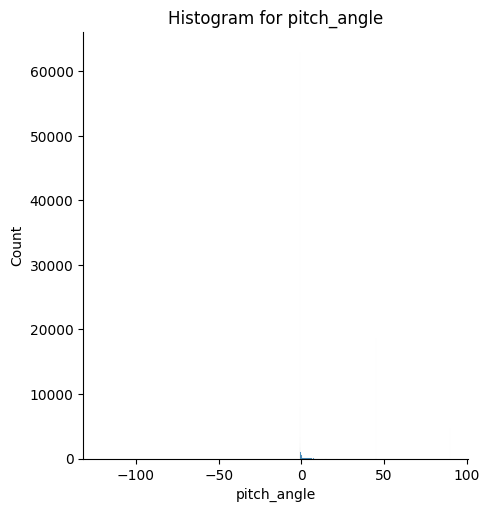

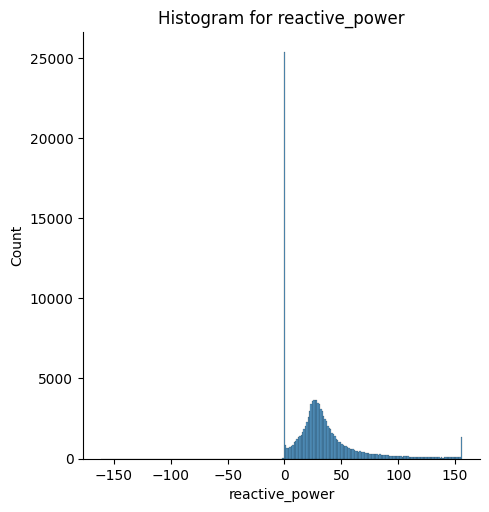

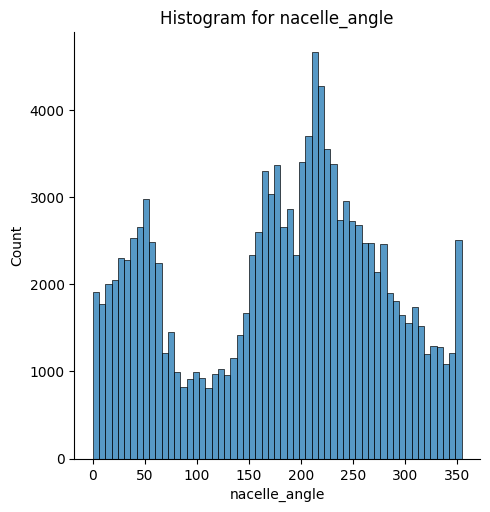

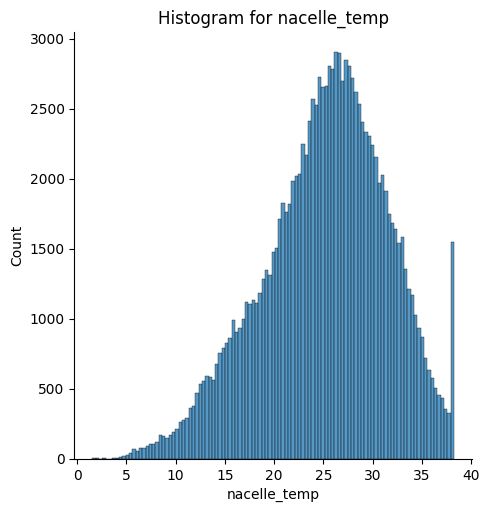

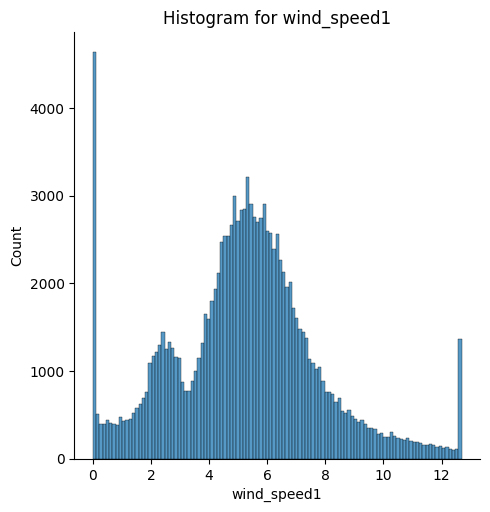

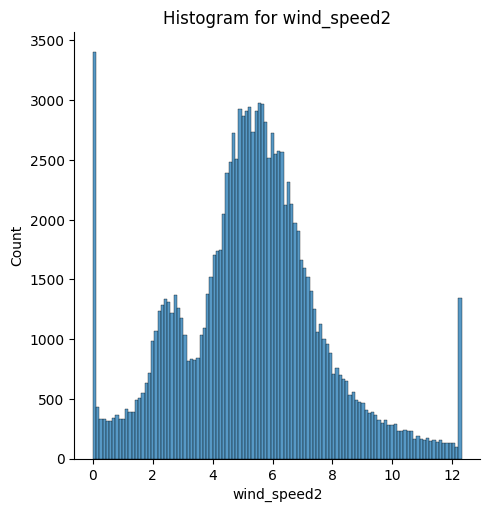

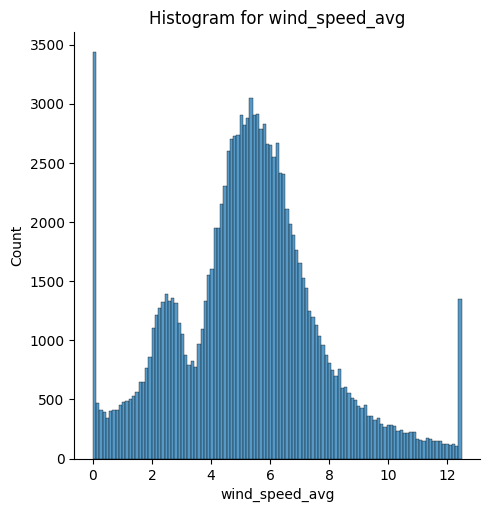

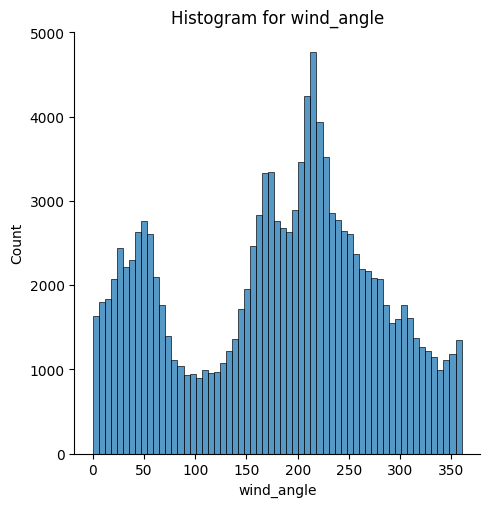

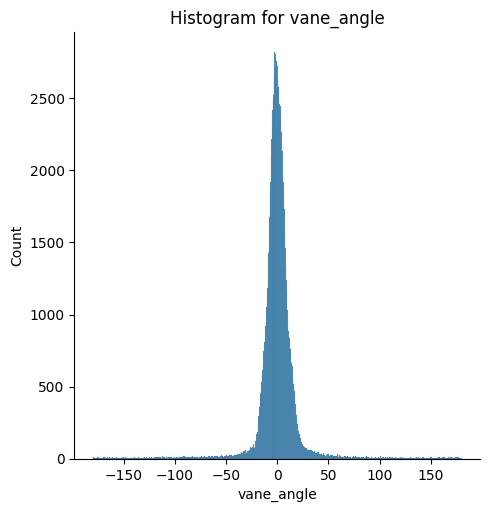

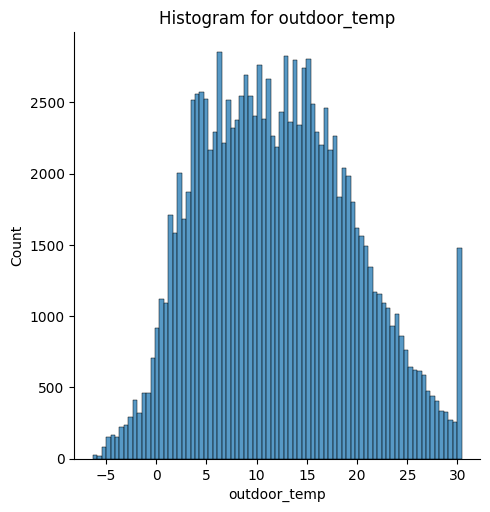

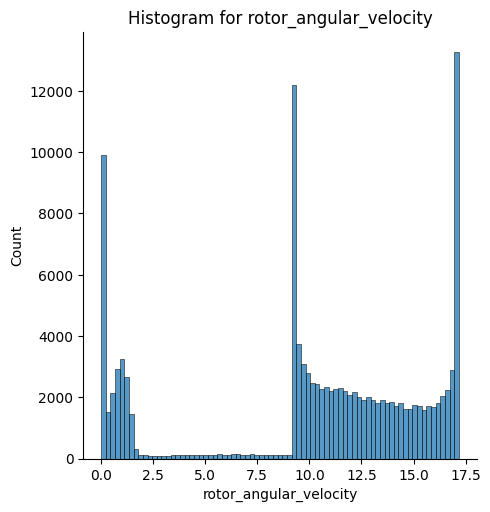

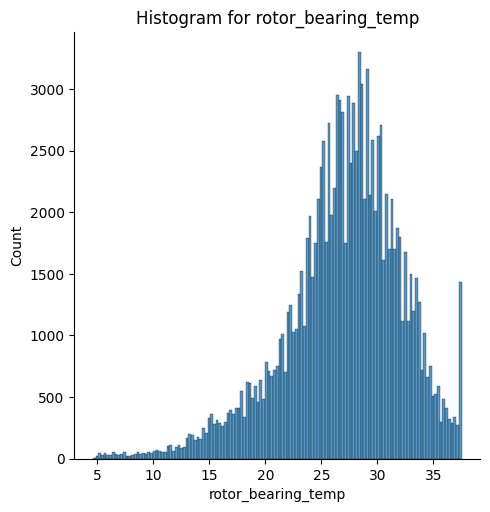

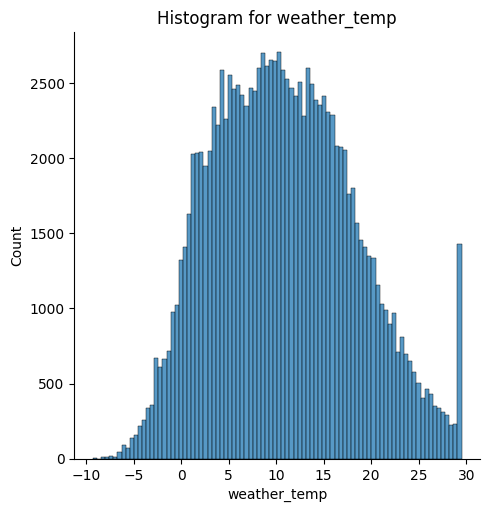

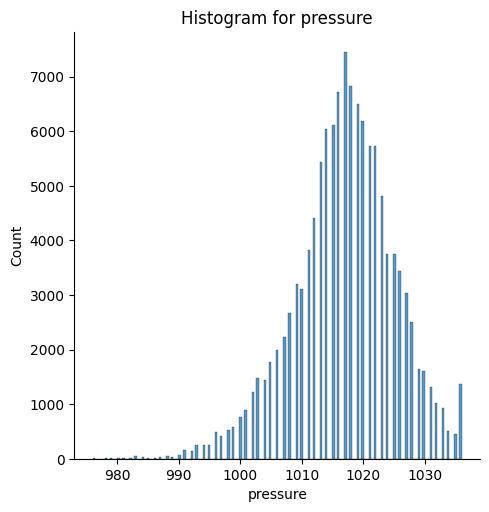

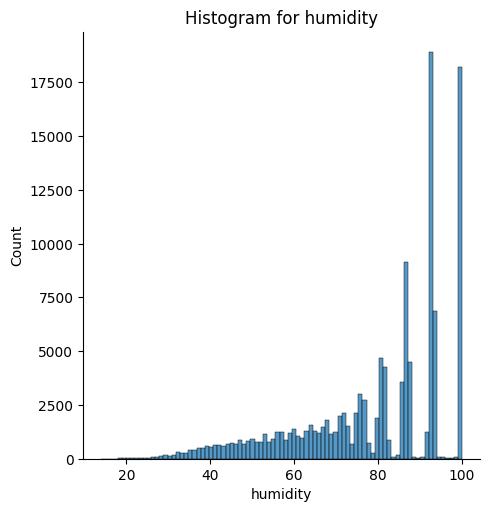

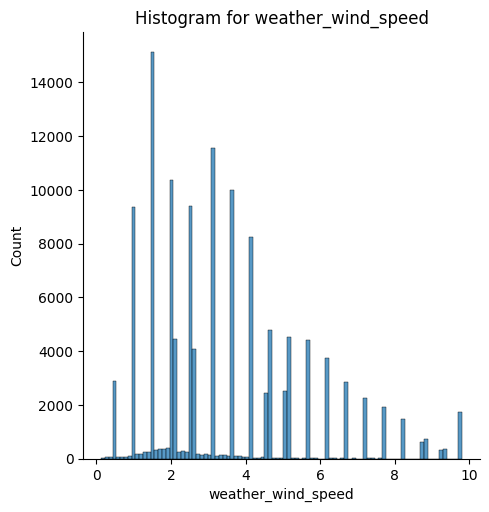

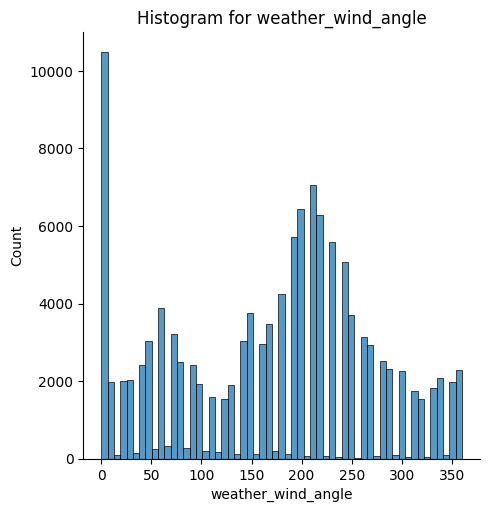

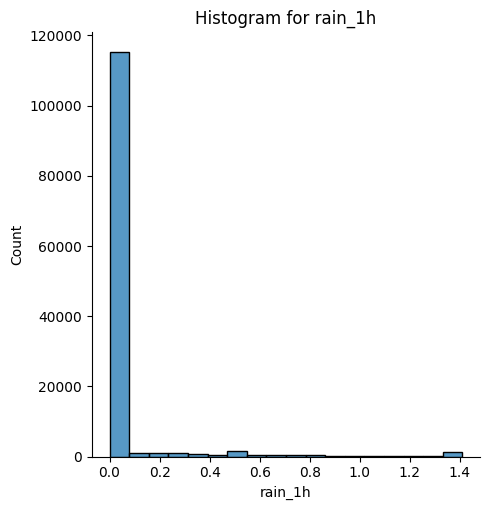

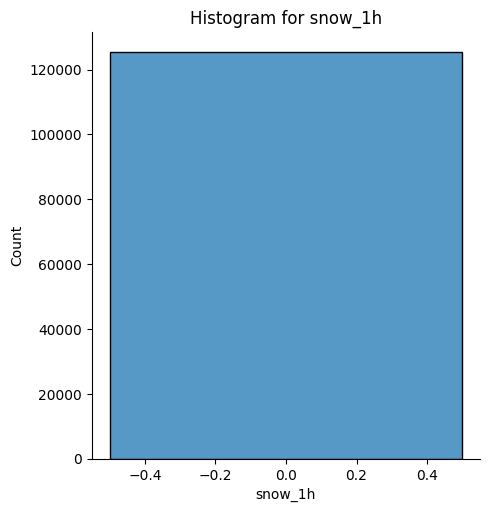

In [30]:
import scipy.stats
from statsmodels.graphics.gofplots import qqplot

# Plot histogram for each continuous feature to see if a transformation is necessary
for feature in ['pitch_angle','reactive_power','nacelle_angle','nacelle_temp','wind_speed1','wind_speed2','wind_speed_avg','wind_angle','vane_angle','outdoor_temp','rotor_angular_velocity','rotor_bearing_temp','weather_temp','pressure','humidity','weather_wind_speed','weather_wind_angle','rain_1h','snow_1h']:
    sns.displot(X_train_clean[feature], kde=False)
    plt.title('Histogram for {}'.format(feature))
    plt.show()

Observations:
1) Data for wind_speed_avg is linear. So no need to apply any transformation.
2) Data for rotor_angular_velocity has an uneven distribution.So will require transformation.
3) Data for weather_wind_speed is more skewed on the left. So will require transformation.
4) Data for reactive_power is more skewed on the right. So it will require transformation.

There are several ways to transform skewed data so that it becomes normally distributed:

-Log transformation: A log transformation can be used to reduce the skewness of data by compressing the range of values. This is particularly useful when the data has a long tail on the right side.

-Square root transformation: A square root transformation can be used to reduce the skewness of data by compressing the range of values. This is particularly useful when the data has a long tail on the right side.

-Box-Cox transformation: The Box-Cox transformation is a family of power transformations that can be used to normalize data. It is particularly useful when the data has a long tail on the left or right side.

-Reciprocal transformation: A reciprocal transformation can be used to reduce the skewness of data by compressing the range of values. This is particularly useful when the data has a long tail on the left side.

-Yeo-Johnson transformation: The Yeo-Johnson transformation is a modified version of the Box-Cox transformation that can be used with both positive and negative data values.

# Box-Cox Power Transformation


*   Determine what range of exponents to test
*   Apply each transformation to each value of your chosen feature
*   Use some criteria to determine which of the transformations yield the best distribution





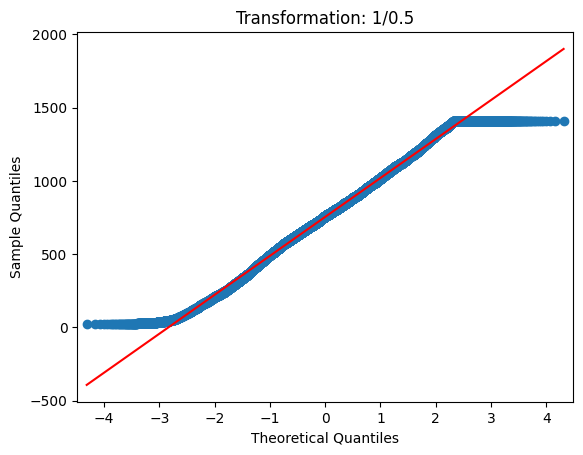

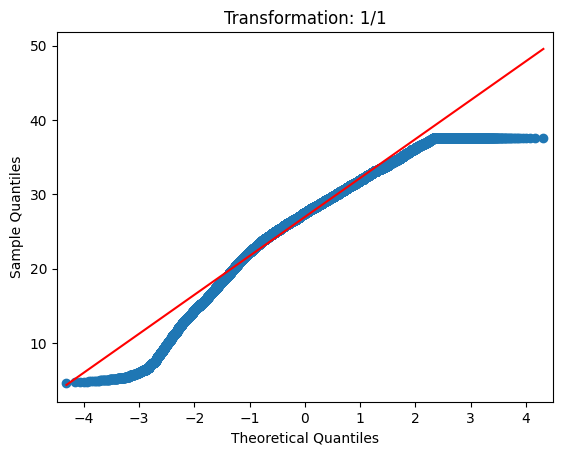

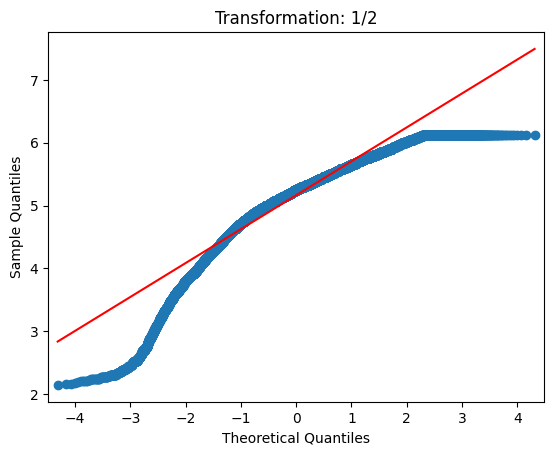

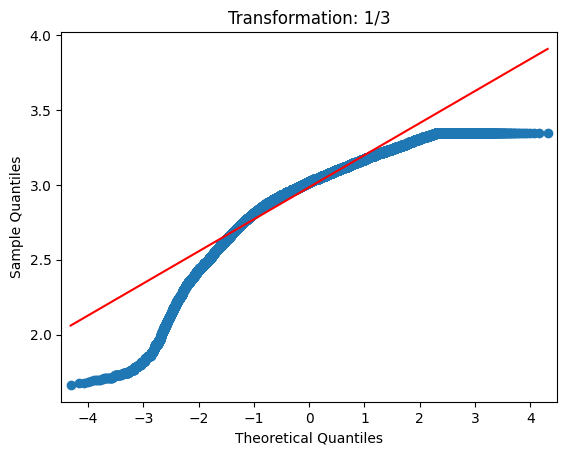

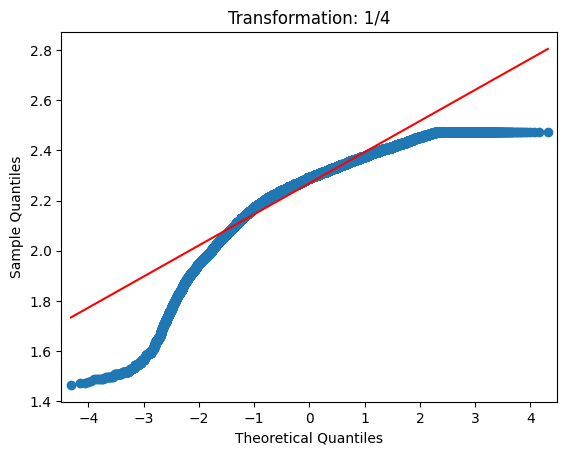

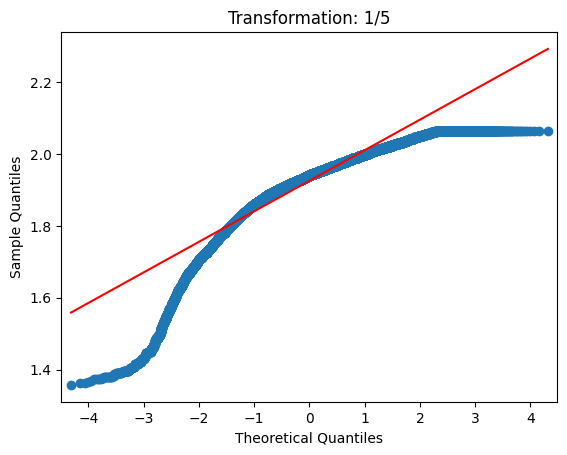

In [34]:
# Generate QQ plots for rotor_angular_velocity
for i in [0.5, 1, 2, 3, 4, 5]:
    data_t = X_train_clean['rotor_bearing_temp']**(1/i)
    qqplot(data_t, line='s')
    plt.title("Transformation: 1/{}".format(str(i)))

0.5 looks like a good choice for normalising rotor_bearing_temp.

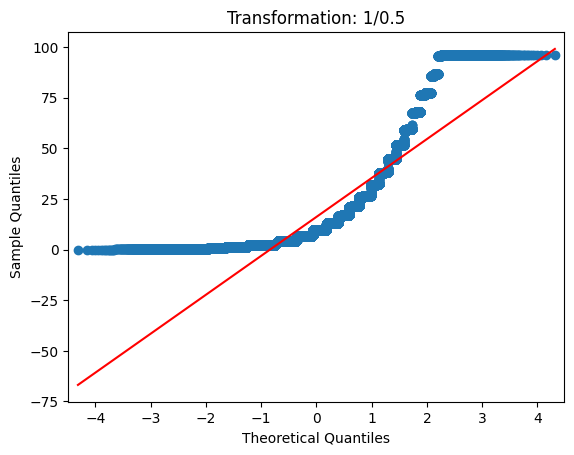

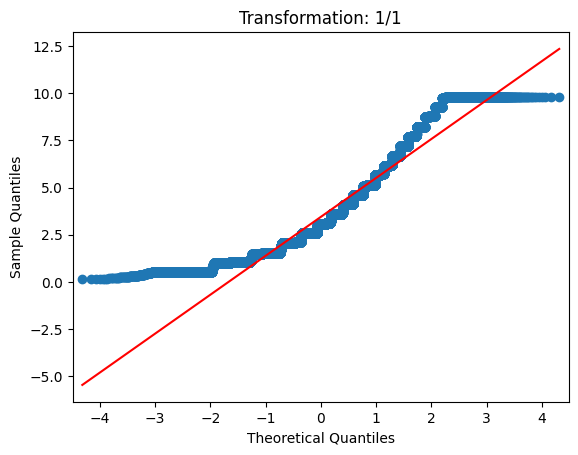

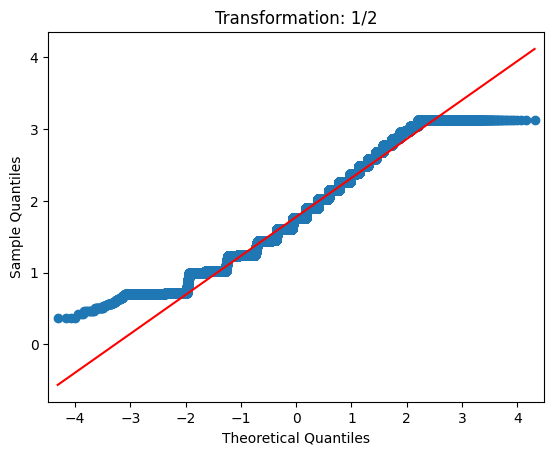

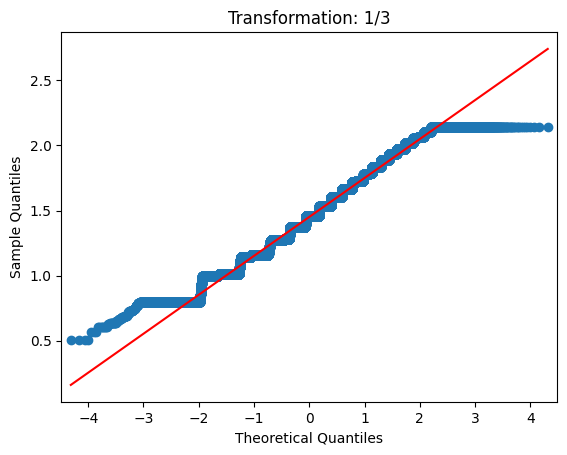

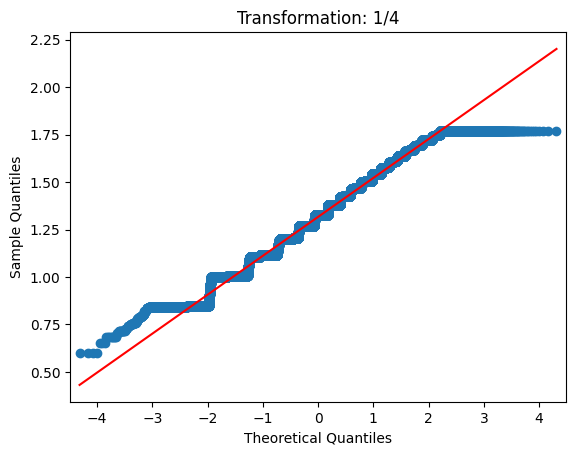

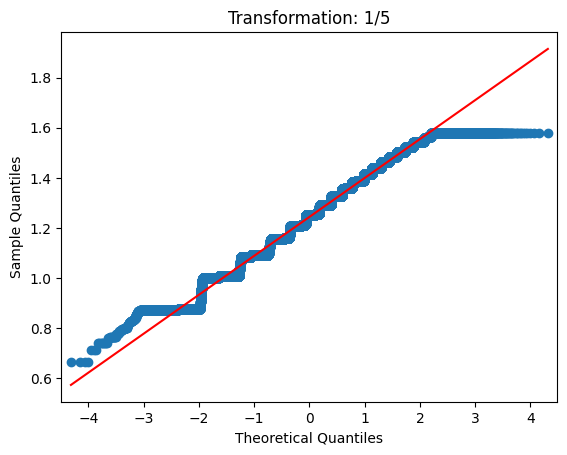

In [35]:
# Generate QQ plots
for i in [0.5, 1, 2, 3, 4, 5]:
    data_t = X_train_clean['weather_wind_speed']**(1/i)
    qqplot(data_t, line='s')
    plt.title("Transformation: 1/{}".format(str(i)))

Observation: Looking at the above graphs, a transformation of 1/5 looked like a good option for weather_wind_speed.

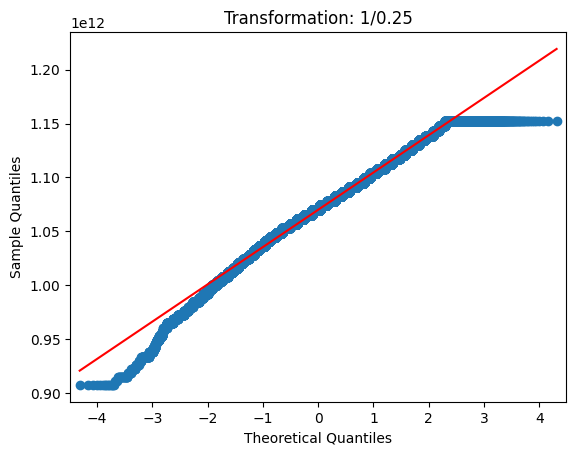

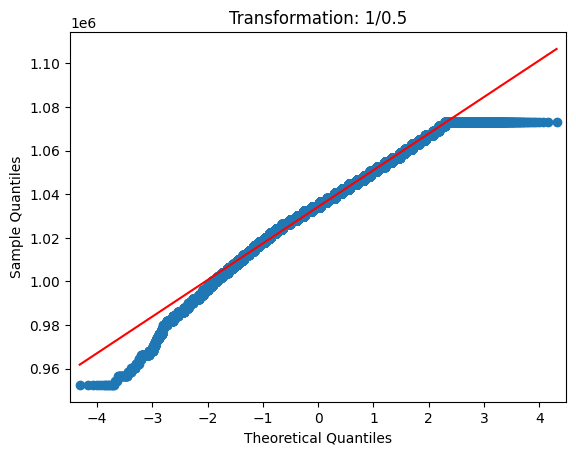

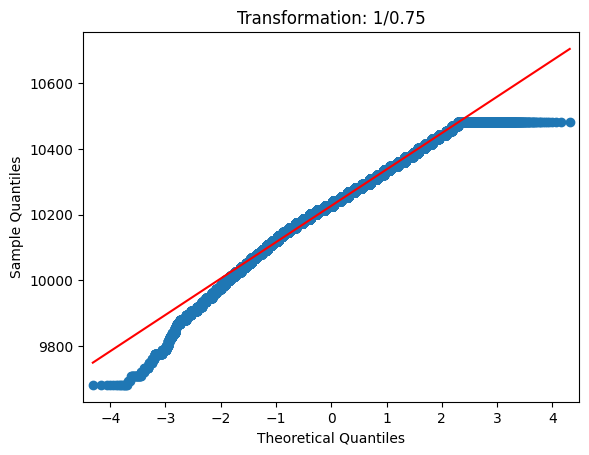

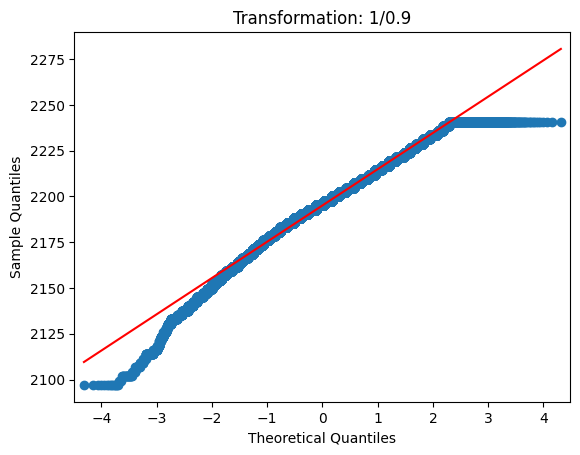

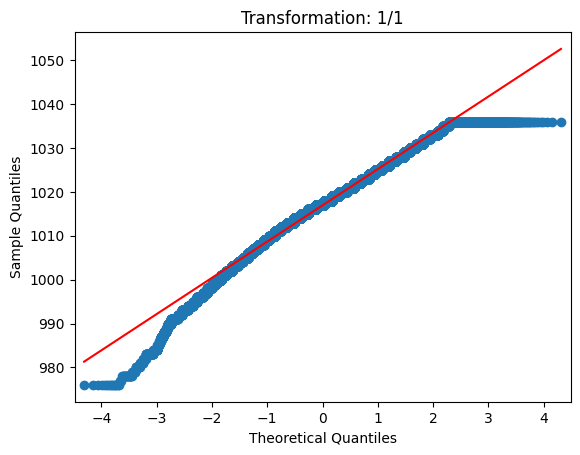

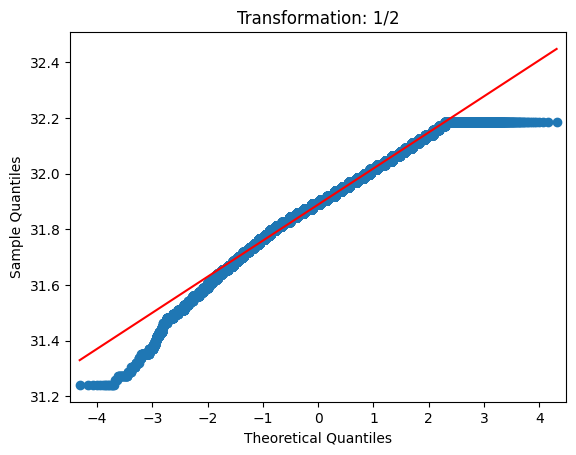

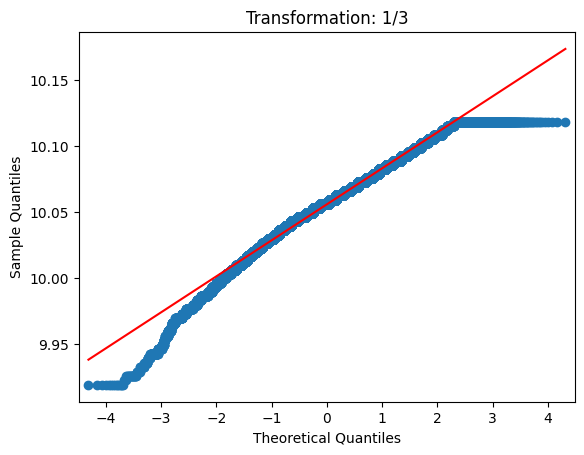

In [37]:
# Generate QQ plots
for i in [0.25,0.5,0.75,0.9, 1, 2,3]:
    data_t = X_train_clean['pressure']**(1/i)
    qqplot(data_t, line='s')
    plt.title("Transformation: 1/{}".format(str(i)))

Observation: Looking at the above graphs, a transformation of 0.25 looked like a good option for pressure.

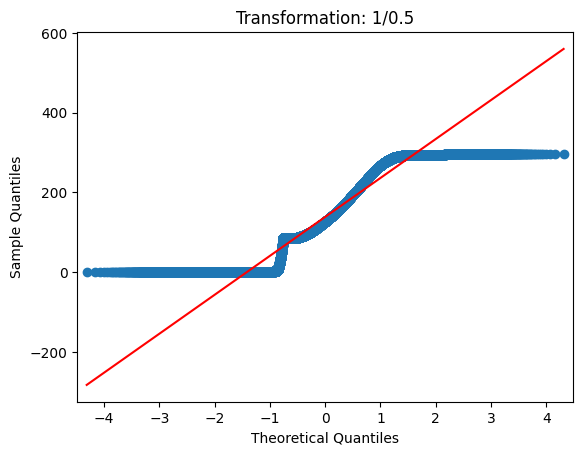

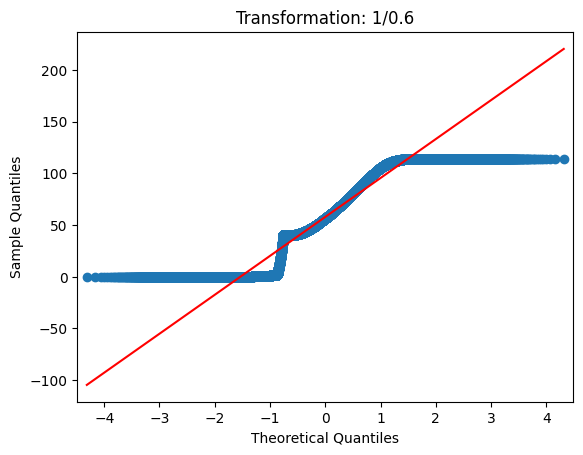

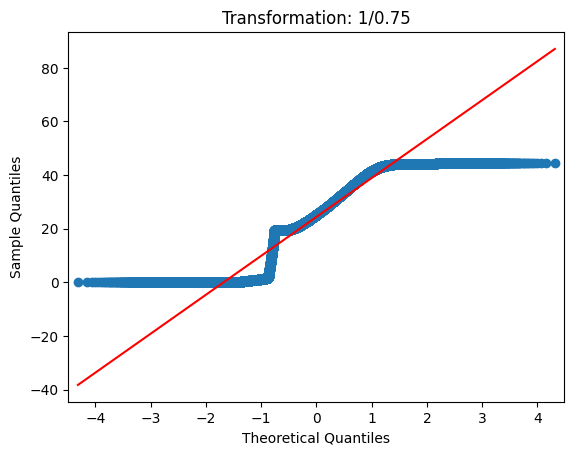

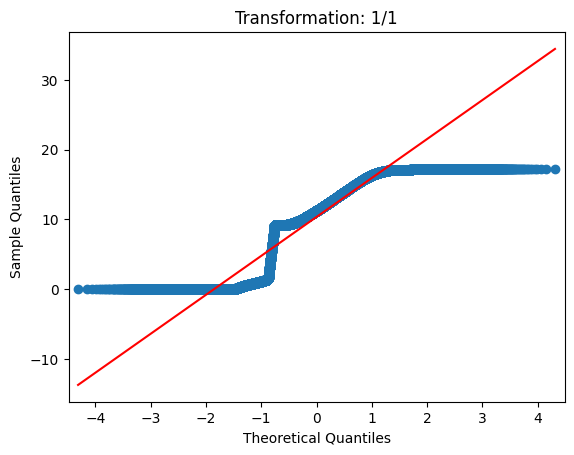

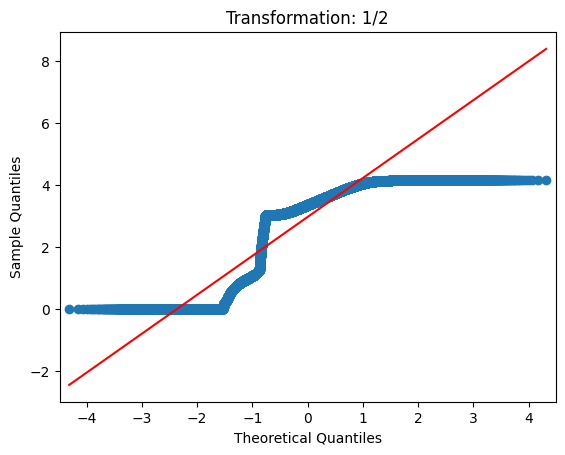

In [39]:
# Generate QQ plots
for i in [0.5,0.6,0.75, 1, 2,]:
    data_t = X_train_clean['rotor_angular_velocity']**(1/i)
    qqplot(data_t, line='s')
    plt.title("Transformation: 1/{}".format(str(i)))


Looking at the above qqplots for rotor_angular_velocity, could not determine a good option to remove skewness.

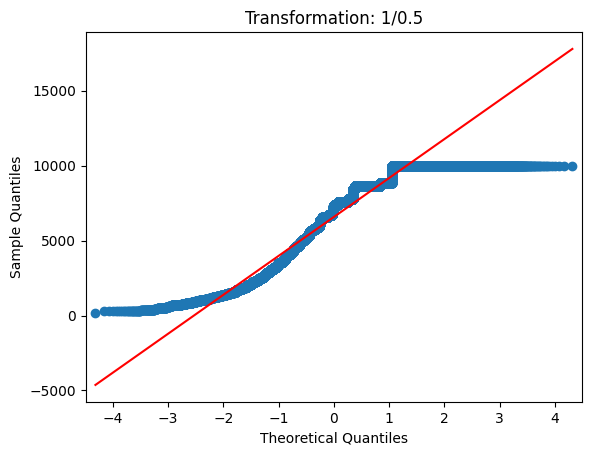

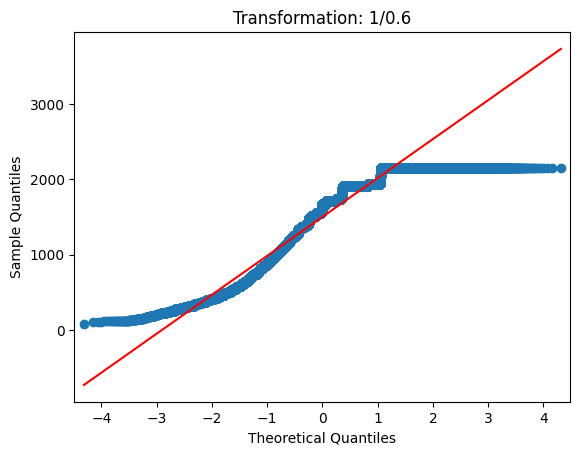

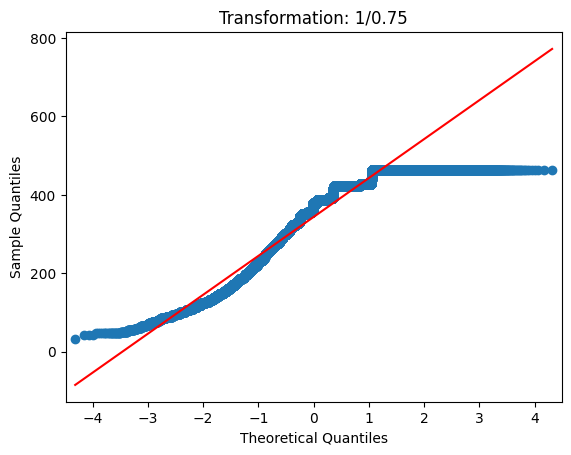

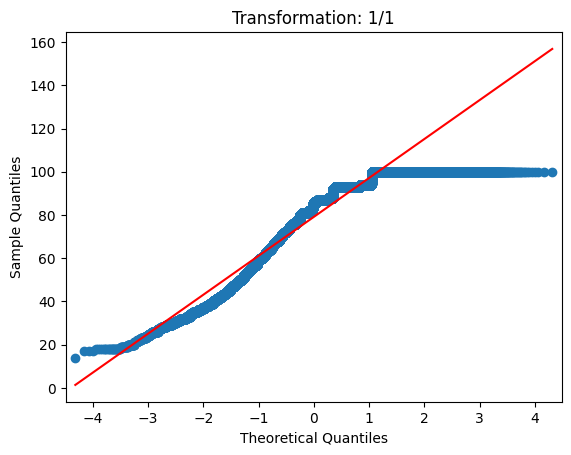

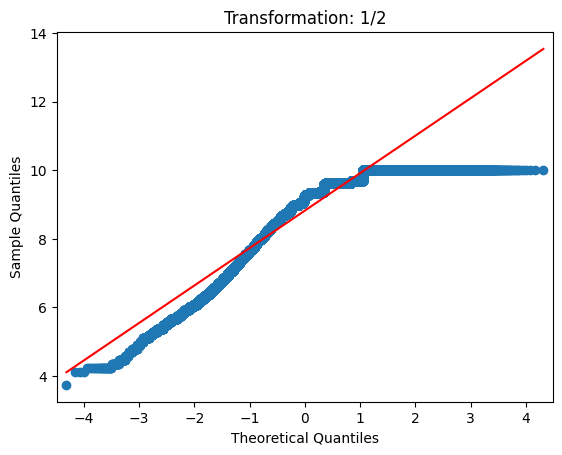

In [40]:
# Generate QQ plots
for i in [0.5,0.6,0.75, 1, 2,]:
    data_t = X_train_clean['humidity']**(1/i)
    qqplot(data_t, line='s')
    plt.title("Transformation: 1/{}".format(str(i)))

In [ ]:
#Not used since Box Cox graphs looked better alligned
# Generate QQ plots
#for i in [1, 2, 3, 4, 5]:
#    data_t = wind_DS_clean['weather_wind_speed']
#    log_data = np.log(data_t)
#   qqplot(log_data, line='s')
#    plt.title("Transformation: log{}".format(str(i)))

In [ ]:
# Create the new transformed feature
wind_DS_clean['weather_wind_speed_tr'] = wind_DS_clean['weather_wind_speed'].apply(lambda x: x**(1/4))
wind_DS_clean['rotor_angular_velocity_tr'] = wind_DS_clean['rotor_angular_velocity'].apply(lambda x: x**(1/0.5))
#wind_DS_clean['active_power_tr'] = np.log(wind_DS_clean['active_power'])
#wind_DS_clean['active_power_tr'] = wind_DS_clean['active_power_tr1'].apply(lambda x: x.real)
wind_DS_clean.head()

,active_power,pitch_angle,reactive_power,nacelle_angle,nacelle_temp,wind_speed1,wind_speed2,wind_speed_avg,wind_angle,vane_angle,...,rotor_angular_velocity,rotor_bearing_temp,weather_temp,pressure,humidity,weather_wind_speed,weather_wind_angle,rain_1h,weather_wind_speed_tr,rotor_angular_velocity_tr
0,801.22998,-1.0,67.559998,286.00000,20.129999,7.52,7.76,7.64,286.19000,0.16,...,16.950001,26.049999,5.39,1011.0,75.0,5.66,180.0,0.0,1.542425,287.302534
1,943.16998,-1.0,70.260002,286.00000,21.420000,8.18,8.45,8.31,288.32999,2.33,...,17.139999,26.100000,5.39,1011.0,75.0,5.66,180.0,0.0,1.542425,293.779566
2,998.48999,-1.0,75.330002,286.00000,22.049999,8.29,8.66,8.47,293.04001,7.01,...,17.150000,26.219999,5.39,1011.0,75.0,5.66,180.0,0.0,1.542425,294.122500
3,837.96002,-1.0,82.739998,286.00000,22.299999,7.89,8.24,8.06,294.01999,8.05,...,16.910000,26.309999,5.39,1011.0,75.0,5.66,180.0,0.0,1.542425,285.948100
4,871.57001,-1.0,82.349998,294.17999,22.600000,7.86,8.20,8.03,299.22000,4.40,...,16.920000,26.389999,5.39,1011.0,75.0,5.66,180.0,0.0,1.542425,286.286400


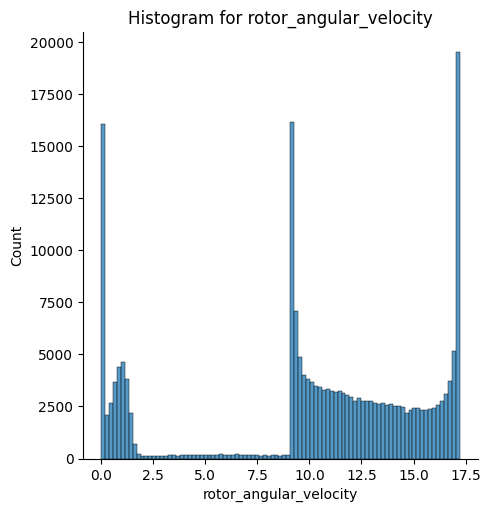

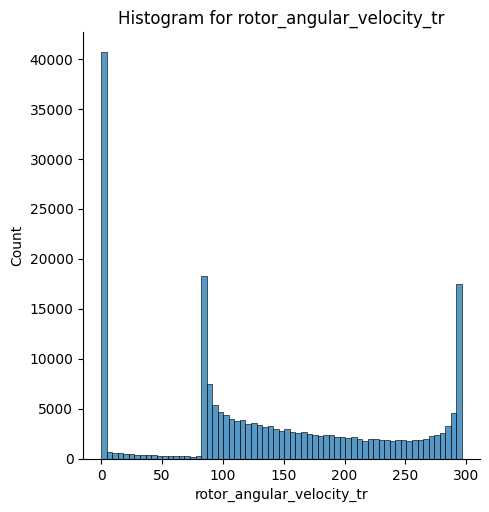

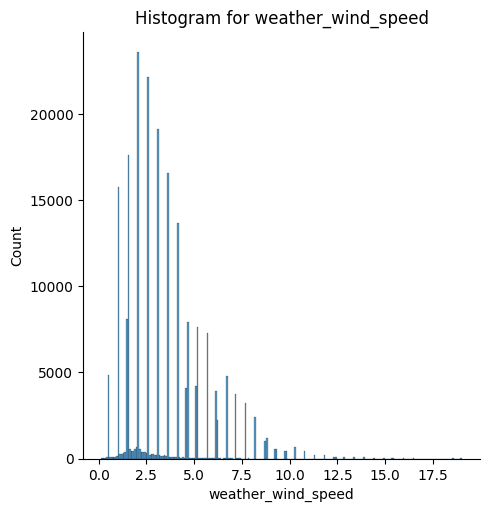

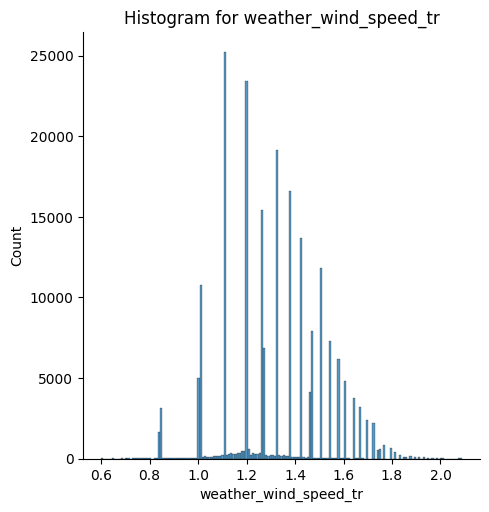

In [ ]:
#recheck the histograms for transformed features
for feature in ['rotor_angular_velocity','rotor_angular_velocity_tr','weather_wind_speed','weather_wind_speed_tr']:
    sns.displot(wind_DS_clean[feature], kde=False)
    plt.title('Histogram for {}'.format(feature))
    plt.show()

We can see the histograms before and after transformation of rotor_angular_velocity and weather_wind_speed. They look more symmetrical than before.

In [32]:
X_train.describe()

,pitch_angle,reactive_power,nacelle_angle,nacelle_temp,wind_speed1,wind_speed2,wind_speed_avg,wind_angle,vane_angle,outdoor_temp,...,outdoor_temp_clean,rotor_angular_velocity_clean,rotor_bearing_temp_clean,weather_temp_clean,pressure_clean,humidity_clean,weather_wind_speed_clean,weather_wind_angle_clean,rain_1h_clean,snow_1h_clean
count,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,...,125346.000000,125346.000000,125346.000000,125346.00000,125346.000000,125346.000000,125346.000000,125346.000000,125346.000000,125346.0
mean,10.596368,31.612017,181.479540,25.243567,5.245423,5.311716,5.265486,179.538223,0.235399,12.150449,...,12.131164,10.367739,26.961255,10.82925,1016.949588,79.087183,3.445819,170.690313,0.050976,0.0
std,23.286006,31.326508,95.959527,6.361582,2.605766,2.476914,2.489758,95.181073,24.305771,7.532662,...,7.481636,5.575875,5.235077,7.40698,8.261659,18.019441,2.064664,100.639957,0.209424,0.0
min,-121.260000,-161.179990,0.040000,1.560000,0.000000,0.000000,0.000000,0.010000,-179.950000,-6.320000,...,-6.320000,0.000000,4.610000,-9.31000,976.000000,14.000000,0.130000,0.000000,0.000000,0.0
25%,-0.990000,9.680000,100.122500,21.219999,3.790000,3.930000,3.860000,98.732502,-5.890000,6.200000,...,6.200000,9.229999,24.260000,5.13000,1012.000000,68.000000,2.060000,80.000000,0.000000,0.0
50%,-0.990000,26.879999,197.810000,25.760000,5.290000,5.350000,5.320000,194.509990,-0.110000,11.790000,...,11.790000,11.250000,27.500000,10.42000,1017.000000,86.000000,3.090000,190.000000,0.000000,0.0
75%,0.500000,40.610001,251.590000,29.709999,6.620000,6.640000,6.630000,248.117500,6.140000,17.389999,...,17.389999,14.860000,30.400000,15.96000,1022.000000,93.000000,4.630000,240.000000,0.000000,0.0
max,112.400000,241.700000,359.920010,42.849998,21.139999,19.990000,12.490000,360.000000,180.000000,37.779999,...,30.410000,17.180000,37.509998,29.51000,1036.000000,100.000000,9.800000,360.000000,1.410000,0.0


Train test split before  feature selection

## Feature Selection

In [31]:
# Feature Selection with Univariate Statistical Tests

from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn import preprocessing
from sklearn import utils
#names = ['pitch_angle','reactive_power','nacelle_angle','nacelle_temp','wind_speed1','wind_speed2','wind_speed_avg','wind_angle','vane_angle','outdoor_temp','rotor_angular_velocity','rotor_bearing_temp','weather_temp','pressure','humidity','weather_wind_speed','weather_wind_angle','rain_1h','snow_1h']
#dataframe = wind_DS_clean[['pitch_angle','reactive_power','nacelle_angle','nacelle_temp','wind_speed1','wind_speed2','wind_speed_avg','wind_angle','vane_angle','outdoor_temp','rotor_angular_velocity_tr','rotor_bearing_temp','weather_temp','pressure','humidity','weather_wind_speed_tr','weather_wind_angle','rain_1h']]
#array = dataframe.values
#X = wind_DS_clean[['pitch_angle','reactive_power','nacelle_angle','nacelle_temp','wind_speed1','wind_speed2','wind_speed_avg','wind_angle','vane_angle','outdoor_temp','rotor_angular_velocity_tr','rotor_bearing_temp','weather_temp','pressure','humidity','weather_wind_speed_tr','weather_wind_angle','rain_1h']]
#Y = wind_DS_clean['active_power']
# feature extraction
#test = SelectKBest(score_func=f_classif, k=4)
#fit = test.fit(X, Y)

lab = preprocessing.LabelEncoder()
Y_transformed = lab.fit_transform(y_train)
test = SelectKBest(mutual_info_classif,k=8)
fit = test.fit_transform(X_train, Y_transformed)
filter = test.get_support()
features = X_train.columns.values
print('All features:')
print(features)
print('Selected Best 8:')
print(features[filter])
print(fit)
# summarize scores
#set_printoptions(precision=3)
#print( fit.scores_)
#features = fit.transform(X)
# summarize selected features
#print(features[0:5,:])

All features:
['pitch_angle' 'reactive_power' 'nacelle_angle' 'nacelle_temp'
 'wind_speed1' 'wind_speed2' 'wind_speed_avg' 'wind_angle' 'vane_angle'
 'outdoor_temp' 'rotor_angular_velocity' 'rotor_bearing_temp'
 'weather_temp' 'pressure' 'humidity' 'weather_wind_speed'
 'weather_wind_angle' 'rain_1h' 'snow_1h' 'pitch_angle_clean'
 'reactive_power_clean' 'nacelle_angle_clean' 'nacelle_temp_clean'
 'wind_speed1_clean' 'wind_speed2_clean' 'wind_angle_avg' 'vane_angle_avg'
 'outdoor_temp_clean' 'rotor_angular_velocity_clean'
 'rotor_bearing_temp_clean' 'weather_temp_clean' 'pressure_clean'
 'humidity_clean' 'weather_wind_speed_clean' 'weather_wind_angle_clean'
 'rain_1h_clean' 'snow_1h_clean']
Selected Best 8:
['pitch_angle' 'wind_speed2' 'wind_speed_avg' 'rotor_angular_velocity'
 'pitch_angle_clean' 'wind_speed1_clean' 'wind_speed2_clean'
 'rotor_angular_velocity_clean']
[[-0.99000001  6.4200001   6.4699998  ...  6.52        6.4200001
  14.97      ]
 [-0.99000001  7.3099999   7.4699998  .

**Features selected** : 'pitch_angle' 'reactive_power' 'wind_speed1' 'wind_speed2'
 'wind_speed_avg' 'vane_angle' 'rotor_angular_velocity_tr'
 'weather_wind_speed_tr'

Notes:
wind_speed_avg is the average of wind_speed1 and wind_speed2. So wind_speed_avg was the feature selected whereas wind_speed1 and wind_speed2 were not selected.

Defining feature X and target Y

In [ ]:
#X = wind_DS_clean[['reactive_power','wind_speed_avg','humidity','weather_wind_speed_tr','weather_wind_angle','rotor_angular_velocity_tr']]
X = wind_DS_clean[['pitch_angle','reactive_power','wind_speed_avg','vane_angle','rotor_angular_velocity_tr','weather_wind_speed_tr']]
X = X.rename(columns={'weather_wind_speed_tr': 'weather_wind_speed'})
X = X.rename(columns={'rotor_angular_velocity_tr': 'rotor_angular_velocity'})
#X = X.rename(columns={'humidity_tr': 'humidity'})
y = wind_DS_clean['active_power']

Dividing data into training and vaidation data set

In [ ]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 100)

Implementing the linear regression

In [ ]:
wind_lr = LinearRegression()
wind_lr.fit(train_X,train_y)

LinearRegression()

In [ ]:
#Prediction of test set

test_data = pd.read_csv('/content/drive/MyDrive/test_data.csv')
#Taking only a subset of columns for test data in the dataframe
test_data_X = test_data[['pitch_angle','reactive_power','wind_speed_avg','vane_angle','rotor_angular_velocity','weather_wind_speed']]
#Predicting the actual_power for the test data set
y_test_data_predict = wind_lr.predict(test_data_X)
#Predicted values for the test data set
print("Prediction of test set: {}".format(y_test_data_predict))

Prediction of test set: [-298.61586929 -283.54906312 -290.30877685 ... -144.16368574   15.09498909
  -42.29806428]


In [ ]:
y_predict = wind_lr.predict(test_X)
#Predicted values for the test data set
print("Prediction of test set: {}".format(y_predict))
wind_lr_dif = pd.DataFrame({"Actual value":test_y, "Predicted value":y_predict})
wind_lr_dif.head()

Prediction of test set: [ 225.59749312 1598.39217741  100.07720541 ...  -47.39888261 -143.80450696
  477.81141669]


,Actual value,Predicted value
186813,188.280000,225.597493
45433,1790.060100,1598.392177
64742,97.010002,100.077205
151113,156.500000,98.692500
24054,0.000000,-65.496896


In [ ]:
meanAbErr = metrics.mean_absolute_error(test_y, y_predict)
meanSqErr = metrics.mean_squared_error(test_y, y_predict)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(test_y, y_predict))
print('R squared: {:.2f}'.format(wind_lr.score(X,y)*100))
print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)

R squared: 92.06
Mean Absolute Error: 89.21030032560576
Mean Square Error: 14472.269070589804
Root Mean Square Error: 120.30074426448826


In [ ]:
submission_MX = pd.DataFrame(data=y_test_data_predict, columns=["active_power"])
submission_MX.reset_index(inplace=True)
submission_MX = submission_MX.rename(columns = {'index':'id'})
submission_MX.head()

,id,active_power
0,0,-298.615869
1,1,-283.549063
2,2,-290.308777
3,3,-288.834440
4,4,-314.239183


**Implementing Ridge regression**

In [ ]:
#Using the linear CV model
from sklearn.linear_model import RidgeCV, Ridge

#Lasso Cross validation
ridge_cv = RidgeCV(alphas = [0.0001, 0.001,0.01, 0.1, 1, 10]).fit(train_X,train_y)

#score
print("The train score for ridge model is {}".format(ridge_cv.score(train_X,train_y)))
print("The test score for ridge model is {}".format(ridge_cv.score(test_X, test_y)))
print("Best alpha: ",ridge_cv.alpha_)

The train score for ridge model is 0.92056003392265
The test score for ridge model is 0.9207116916355821
Best alpha:  10.0


**Implementing Lasso regression**

In [ ]:
#Using the linear CV model
from sklearn.linear_model import LassoCV

#Lasso Cross validation
lasso_cv = LassoCV(alphas = [0.0001, 0.001,0.01, 0.1, 1, 10], random_state=0).fit(train_X,train_y)


#score
print("The train score for lasso model is {}".format(lasso_cv.score(train_X,train_y)))
print("The test score for lasso model is {}".format(lasso_cv.score(test_X, test_y)))
print("Best alpha: ",lasso_cv.alpha_)

The train score for lasso model is 0.9205600368071999
The test score for lasso model is 0.9207117059236883
Best alpha:  0.0001


Plot linear, ridge, lasso graph

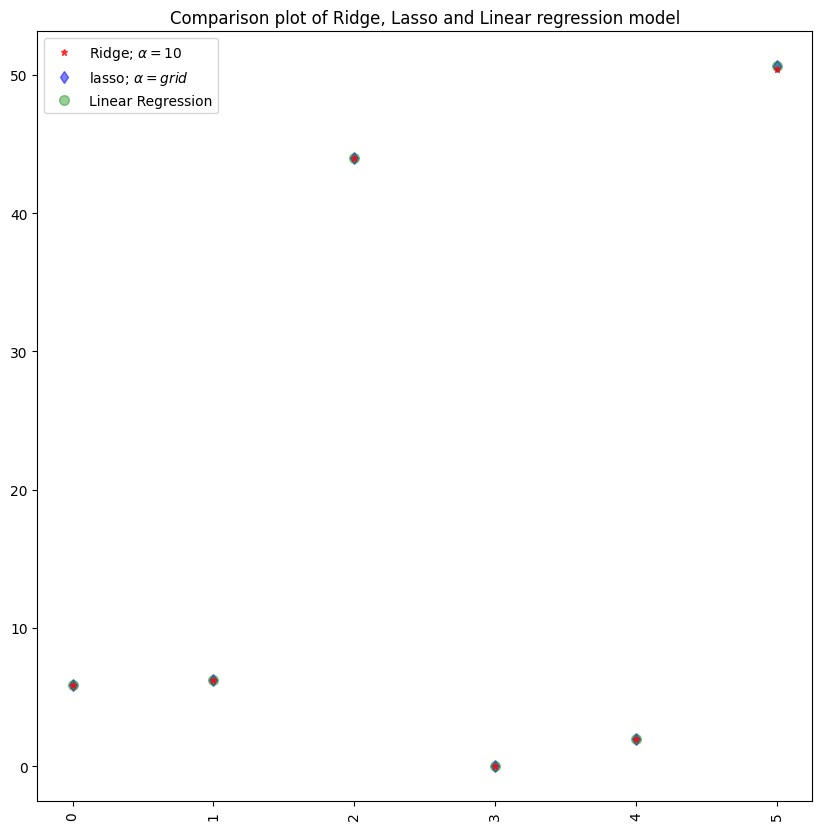

In [ ]:
#plot size
plt.figure(figsize = (10, 10))
#add plot for ridge regression
plt.plot(ridge_cv.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 10$',zorder=7)

#add plot for lasso regression
plt.plot(lasso_cv.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'lasso; $\alpha = grid$')

#add plot for linear model
plt.plot(wind_lr.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')

#rotate axis
plt.xticks(rotation = 90)
plt.legend()
plt.title("Comparison plot of Ridge, Lasso and Linear regression model")
plt.show()

Observation: When the Ridge and Lasso models give the same result as the linear model, it means that the penalty term is not having any effect on the coefficients. This can happen when the predictor variables are not highly correlated with each other, so the coefficients of the linear model are already stable and easy to interpret.

Implementing Random Forest

In [ ]:
#from sklearn.tree import DecisionTreeRegressor
#tree_model = DecisionTreeRegressor()
#tree_model.fit(train_X, train_y)

#from sklearn import RandomForestRegressor
wind_RF= RandomForestRegressor(n_estimators=100, random_state=0)
wind_RF.fit(train_X,train_y)

RandomForestRegressor(random_state=0)

In [ ]:
#train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = 100)
y_predict = wind_RF.predict(test_X)
meanAbErr = metrics.mean_absolute_error(test_y, y_predict)
meanSqErr = metrics.mean_squared_error(test_y, y_predict)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(test_y, y_predict))
print('R squared: {:.2f}'.format(wind_lr.score(X,y)*100))
print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)
wind_RF.score(X,y)

R squared: 92.06
Mean Absolute Error: 11.54398957091849
Mean Square Error: 600.5850474641995
Root Mean Square Error: 24.506836749450134


0.9986759631575086

In [ ]:
#Predicted values for the test data set
print("Prediction of test set: {}".format(y_predict))
wind_regr_dif = pd.DataFrame({"Actual value":test_y, "Predicted value":y_predict})
wind_regr_dif.head()

Prediction of test set: [ 1.96910399e+02  1.79179281e+03  1.01311700e+02 ... -7.35900001e-01
 -1.07180001e+00  4.14518702e+02]


,Actual value,Predicted value
186813,188.280000,196.910399
45433,1790.060100,1791.792814
64742,97.010002,101.311700
151113,156.500000,152.035900
24054,0.000000,-0.294300


from matplotlib import pyplot as plt
_df_0['Actual value'].plot(kind='hist', bins=20, title='Actual value')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Predicted value'].plot(kind='hist', bins=20, title='Predicted value')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='Actual value', y='Predicted value', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Actual value'].plot(kind='line', figsize=(8, 4), title='Actual value')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['Predicted value'].plot(kind='line', figsize=(8, 4), title='Predicted value')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
#Prediction of test set
#Reading test data file
test_data = pd.read_csv('/content/drive/MyDrive/test_data.csv')
#Taking only a subset of columns for test data in the dataframe
#test_data_X = test_data[['pitch_angle','reactive_power','nacelle_temp','wind_speed_avg','rotor_angular_velocity']]
test_data_X = test_data[['pitch_angle','reactive_power','wind_speed_avg','vane_angle','rotor_angular_velocity','weather_wind_speed']]
#Predicting the actual_power for the test data set
y_test_data_predict = wind_RF.predict(test_data_X)
#Predicted values for the test data set
print("Prediction of test set: {}".format(y_test_data_predict))

Prediction of test set: [-1.81169998  5.55839997 -0.28249999 ... -3.80509991 -1.48860001
 -1.33      ]


In [ ]:
submission_MX = pd.DataFrame(data=y_test_data_predict, columns=["active_power"])
submission_MX.reset_index(inplace=True)
submission_MX = submission_MX.rename(columns = {'index':'id'})
submission_MX.head()

,id,active_power
0,0,-1.8117
1,1,5.5584
2,2,-0.2825
3,3,-1.0851
4,4,3.4056


In [ ]:
submission_MX.to_csv("active_power_submission_RF_correct.csv", index=False)

In [ ]:
# Create new CSV with updated clean and transformed data
wind_DS_clean.to_csv('/content/drive/MyDrive/WindPrediction_Extraction2/wind_DS_clean.csv', index=False)

New train test split with 3 groups: training set, validation set and test set

In [ ]:
wind_DS_clean = pd.read_csv('/content/drive/MyDrive/WindPrediction_Extraction2/wind_DS_clean.csv')
wind_DS_clean.head()

,active_power,pitch_angle,reactive_power,nacelle_angle,nacelle_temp,wind_speed1,wind_speed2,wind_speed_avg,wind_angle,vane_angle,...,rotor_angular_velocity,rotor_bearing_temp,weather_temp,pressure,humidity,weather_wind_speed,weather_wind_angle,rain_1h,weather_wind_speed_tr,rotor_angular_velocity_tr
0,801.22998,-1.0,67.559998,286.00000,20.129999,7.52,7.76,7.64,286.19000,0.16,...,16.950001,26.049999,5.39,1011.0,75.0,5.66,180.0,0.0,1.542425,287.302534
1,943.16998,-1.0,70.260002,286.00000,21.420000,8.18,8.45,8.31,288.32999,2.33,...,17.139999,26.100000,5.39,1011.0,75.0,5.66,180.0,0.0,1.542425,293.779566
2,998.48999,-1.0,75.330002,286.00000,22.049999,8.29,8.66,8.47,293.04001,7.01,...,17.150000,26.219999,5.39,1011.0,75.0,5.66,180.0,0.0,1.542425,294.122500
3,837.96002,-1.0,82.739998,286.00000,22.299999,7.89,8.24,8.06,294.01999,8.05,...,16.910000,26.309999,5.39,1011.0,75.0,5.66,180.0,0.0,1.542425,285.948100
4,871.57001,-1.0,82.349998,294.17999,22.600000,7.86,8.20,8.03,299.22000,4.40,...,16.920000,26.389999,5.39,1011.0,75.0,5.66,180.0,0.0,1.542425,286.286400


In [ ]:
# Drop unnecccessary features and split into training/test sets
features = wind_DS_clean.drop(['wind_speed1', 'wind_speed2', 'active_power'], axis=1)
labels = wind_DS_clean['active_power']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

X_train.head()

,pitch_angle,reactive_power,nacelle_angle,nacelle_temp,wind_speed_avg,wind_angle,vane_angle,outdoor_temp,rotor_angular_velocity,rotor_bearing_temp,weather_temp,pressure,humidity,weather_wind_speed,weather_wind_angle,rain_1h,weather_wind_speed_tr,rotor_angular_velocity_tr
140902,-0.99,19.250000,171.47000,30.799999,6.47,171.91000,0.47,17.32,14.970000,32.299999,18.01,1013.0,93.0,4.60,200.0,0.00,1.464500,224.100900
134186,-0.99,58.070000,228.53999,29.500000,7.47,223.73000,-4.82,16.75,16.500000,32.000000,17.08,1012.0,63.0,6.20,230.0,0.00,1.577967,272.250000
140371,-0.99,35.990002,34.27000,28.580000,6.80,41.77000,7.52,13.62,15.480000,30.510000,11.33,1021.0,76.0,3.10,60.0,0.00,1.326907,239.630400
74330,-0.17,3.880000,192.32001,18.700001,3.60,191.94000,-0.43,13.96,9.229999,29.080000,13.13,1009.0,88.0,3.09,200.0,0.75,1.325835,85.192891
92048,45.00,-0.010000,270.51999,27.959999,2.85,314.10001,14.16,15.22,1.200000,26.000000,14.87,1016.0,88.0,1.54,10.0,0.00,1.113987,1.440000


In [ ]:
#Verify train, validation,test split of data
for dataset in [y_train, y_val, y_test]:
    print(round(len(dataset) / len(labels), 2))

0.6
0.2
0.2


In [ ]:
X_train.to_csv('/content/drive/MyDrive/WindPrediction_Extraction2/train_features.csv', index=False)
X_val.to_csv('/content/drive/MyDrive/WindPrediction_Extraction2/val_features.csv', index=False)
X_test.to_csv('/content/drive/MyDrive/WindPrediction_Extraction2/test_features.csv', index=False)

y_train.to_csv('/content/drive/MyDrive/WindPrediction_Extraction2/train_labels.csv', index=False)
y_val.to_csv('/content/drive/MyDrive/WindPrediction_Extraction2/val_labels.csv', index=False)
y_test.to_csv('/content/drive/MyDrive/WindPrediction_Extraction2/test_labels.csv', index=False)

# Prepare Features For Modeling: Standardize All Features

In [ ]:
wind_DS_train = pd.read_csv('/content/drive/MyDrive/WindPrediction_Extraction2/train_features.csv')
wind_DS_val = pd.read_csv('/content/drive/MyDrive/WindPrediction_Extraction2/val_features.csv')
wind_DS_test = pd.read_csv('/content/drive/MyDrive/WindPrediction_Extraction2/test_features.csv')
wind_DS_train.head()

,pitch_angle,reactive_power,nacelle_angle,nacelle_temp,wind_speed_avg,wind_angle,vane_angle,outdoor_temp,rotor_angular_velocity,rotor_bearing_temp,weather_temp,pressure,humidity,weather_wind_speed,weather_wind_angle,rain_1h,weather_wind_speed_tr,rotor_angular_velocity_tr
0,-0.99,19.250000,171.47000,30.799999,6.47,171.91000,0.47,17.32,14.970000,32.299999,18.01,1013.0,93.0,4.60,200.0,0.00,1.464500,224.100900
1,-0.99,58.070000,228.53999,29.500000,7.47,223.73000,-4.82,16.75,16.500000,32.000000,17.08,1012.0,63.0,6.20,230.0,0.00,1.577967,272.250000
2,-0.99,35.990002,34.27000,28.580000,6.80,41.77000,7.52,13.62,15.480000,30.510000,11.33,1021.0,76.0,3.10,60.0,0.00,1.326907,239.630400
3,-0.17,3.880000,192.32001,18.700001,3.60,191.94000,-0.43,13.96,9.229999,29.080000,13.13,1009.0,88.0,3.09,200.0,0.75,1.325835,85.192891
4,45.00,-0.010000,270.51999,27.959999,2.85,314.10001,14.16,15.22,1.200000,26.000000,14.87,1016.0,88.0,1.54,10.0,0.00,1.113987,1.440000


# Standardize Features

In [ ]:
# Fit the scaler on the training data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(wind_DS_train)

StandardScaler()

In [ ]:
# Scale the training, test, and validation sets
features = wind_DS_train.columns

wind_DS_train[features] = scaler.transform(wind_DS_train[features])
wind_DS_val[features] = scaler.transform(wind_DS_val[features])
wind_DS_test[features] = scaler.transform(wind_DS_test[features])

wind_DS_train.head()

,pitch_angle,reactive_power,nacelle_angle,nacelle_temp,wind_speed_avg,wind_angle,vane_angle,outdoor_temp,rotor_angular_velocity,rotor_bearing_temp,weather_temp,pressure,humidity,weather_wind_speed,weather_wind_angle,rain_1h,weather_wind_speed_tr,rotor_angular_velocity_tr
0,-0.497932,-0.398110,-0.104310,0.873439,0.470176,-0.080145,0.029954,0.686288,0.825376,1.014232,0.958991,-0.477611,0.772103,0.532312,0.291234,-0.242859,0.711872,0.875727
1,-0.497932,0.867141,0.490422,0.669087,0.864823,0.464293,-0.209811,0.610617,1.099771,0.957142,0.834418,-0.597979,-0.892772,1.282051,0.589328,-0.242859,1.260316,1.368780
2,-0.497932,0.147493,-1.534086,0.524468,0.600410,-1.447439,0.349490,0.195091,0.916841,0.673591,0.064210,0.485330,-0.171326,-0.170569,-1.099869,-0.242859,0.046811,1.034751
3,-0.462657,-0.899061,0.112970,-1.028611,-0.662459,0.130297,-0.010838,0.240228,-0.204053,0.401459,0.305319,-0.959081,0.494624,-0.175255,0.291234,3.316390,0.041633,-0.546707
4,1.480500,-1.025847,0.927900,0.427007,-0.958444,1.413751,0.650443,0.407501,-1.644178,-0.184672,0.538390,-0.116508,0.494624,-0.901565,-1.596691,-0.242859,-0.982341,-1.404347


In [ ]:
# Define the list of features to be used for each dataset
#raw_original_features = ['reactive_power','wind_speed_avg','humidity','weather_wind_speed','weather_wind_angle','rotor_angular_velocity']
raw_original_features = ['pitch_angle','reactive_power','wind_speed_avg','vane_angle','rotor_angular_velocity','weather_wind_speed']
#cleaned_original_features = ['reactive_power','wind_speed_avg','humidity','weather_wind_speed_tr','weather_wind_angle','rotor_angular_velocity_tr']
cleaned_original_features = ['pitch_angle','reactive_power','wind_speed_avg','vane_angle','rotor_angular_velocity_tr','weather_wind_speed_tr']
#all_features = ['pitch_angle','reactive_power','nacelle_angle','nacelle_temp','wind_speed_avg','wind_angle','vane_angle','outdoor_temp','rotor_angular_velocity','rotor_bearing_temp','weather_temp','pressure','humidity','weather_wind_speed','weather_wind_angle','rain_1h','weather_wind_speed_tr','rotor_angular_velocity_tr']
all_features = ['pitch_angle','reactive_power','nacelle_angle','nacelle_temp','wind_speed_avg','wind_angle','vane_angle','outdoor_temp','rotor_angular_velocity','rotor_bearing_temp','weather_temp','pressure','humidity','weather_wind_speed','weather_wind_angle','rain_1h','weather_wind_speed_tr','rotor_angular_velocity_tr']


In [ ]:
# Write out final data for each feature set
wind_DS_train[raw_original_features].to_csv('/content/drive/MyDrive/WindPrediction_Extraction2/train_features_raw.csv', index=False)
wind_DS_val[raw_original_features].to_csv('/content/drive/MyDrive/WindPrediction_Extraction2/val_features_raw.csv', index=False)
wind_DS_test[raw_original_features].to_csv('/content/drive/MyDrive/WindPrediction_Extraction2/test_features_raw.csv', index=False)

wind_DS_train[cleaned_original_features].to_csv('/content/drive/MyDrive/WindPrediction_Extraction2/train_features_original.csv', index=False)
wind_DS_val[cleaned_original_features].to_csv('/content/drive/MyDrive/WindPrediction_Extraction2/val_features_original.csv', index=False)
wind_DS_test[cleaned_original_features].to_csv('/content/drive/MyDrive/WindPrediction_Extraction2/test_features_original.csv', index=False)

wind_DS_train[all_features].to_csv('/content/drive/MyDrive/WindPrediction_Extraction2/train_features_all.csv', index=False)
wind_DS_val[all_features].to_csv('/content/drive/MyDrive/WindPrediction_Extraction2/val_features_all.csv', index=False)
wind_DS_test[all_features].to_csv('/content/drive/MyDrive/WindPrediction_Extraction2/test_features_all.csv', index=False)

In [ ]:
# Read in all labels
wind_DS_train_labels = pd.read_csv('/content/drive/MyDrive/WindPrediction_Extraction2/train_labels.csv')
wind_DS_val_labels = pd.read_csv('/content/drive/MyDrive/WindPrediction_Extraction2/val_labels.csv')
wind_DS_test_labels = pd.read_csv('/content/drive/MyDrive/WindPrediction_Extraction2/test_labels.csv')

In [ ]:
# Double-check the labels
wind_DS_train_labels

,active_power
0,471.16000
1,692.38000
2,516.71002
3,24.17000
4,-1.12000
...,...
125341,1089.79000
125342,182.03999
125343,212.49001
125344,247.89999


# Build Models To Compare Features: Raw Original Features

In [ ]:
from sklearn.model_selection import GridSearchCV
train_features = pd.read_csv('/content/drive/MyDrive/WindPrediction_Extraction2/train_features_raw.csv')
train_labels = pd.read_csv('/content/drive/MyDrive/WindPrediction_Extraction2/train_labels.csv')

train_features.head()

,pitch_angle,reactive_power,wind_speed_avg,vane_angle,rotor_angular_velocity,weather_wind_speed
0,-0.497932,-0.398110,0.470176,0.029954,0.825376,0.532312
1,-0.497932,0.867141,0.864823,-0.209811,1.099771,1.282051
2,-0.497932,0.147493,0.600410,0.349490,0.916841,-0.170569
3,-0.462657,-0.899061,-0.662459,-0.010838,-0.204053,-0.175255
4,1.480500,-1.025847,-0.958444,0.650443,-1.644178,-0.901565


<Axes: >

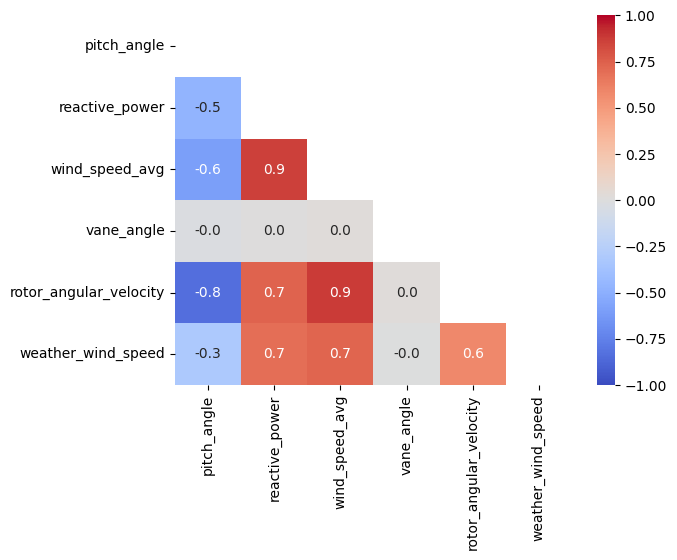

In [ ]:
# Generate correlation matrix heat map
matrix = np.triu(train_features.corr())
sns.heatmap(train_features.corr(), annot=True, fmt='.1f', vmin=-1, vmax=1, center= 0, cmap='coolwarm', mask=matrix)

In [ ]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [ ]:
# Conduct search for best params while running cross-validation (GridSearchCV)
rf = RandomForestRegressor()
parameters = {
    'n_estimators': [100,150,200],
    'max_depth': [4, 8, 16]
}

cv = GridSearchCV(rf, parameters, cv=5)
cv.fit(train_features, train_labels.values.ravel())

print_results(cv)

BEST PARAMS: {'max_depth': 16, 'n_estimators': 200}

0.99 (+/-0.001) for {'max_depth': 4, 'n_estimators': 100}
0.99 (+/-0.001) for {'max_depth': 4, 'n_estimators': 150}
0.99 (+/-0.001) for {'max_depth': 4, 'n_estimators': 200}
0.996 (+/-0.0) for {'max_depth': 8, 'n_estimators': 100}
0.996 (+/-0.0) for {'max_depth': 8, 'n_estimators': 150}
0.996 (+/-0.0) for {'max_depth': 8, 'n_estimators': 200}
0.997 (+/-0.0) for {'max_depth': 16, 'n_estimators': 100}
0.997 (+/-0.0) for {'max_depth': 16, 'n_estimators': 150}
0.997 (+/-0.0) for {'max_depth': 16, 'n_estimators': 200}


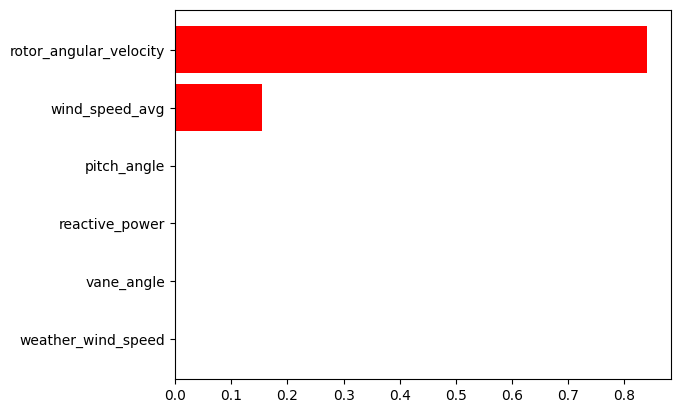

In [ ]:
# Generate feature importance plot
feat_imp = cv.best_estimator_.feature_importances_
indices = np.argsort(feat_imp)
plt.yticks(range(len(indices)), [train_features.columns[i] for i in indices])
plt.barh(range(len(indices)), feat_imp[indices], color='r', align='center')
plt.show()

In [ ]:
# Write out the model fit on the whole training set
import joblib
joblib.dump(cv.best_estimator_, '/content/drive/MyDrive/WindPrediction_Extraction2/models/mdl_raw_original_features.pkl')

['/content/drive/MyDrive/WindPrediction_Extraction2/models/mdl_raw_original_features.pkl']

# Build Models To Compare Features: Cleaned Original Features

In [ ]:
from sklearn.model_selection import GridSearchCV
train_features = pd.read_csv('/content/drive/MyDrive/WindPrediction_Extraction2/train_features_original.csv')
train_labels = pd.read_csv('/content/drive/MyDrive/WindPrediction_Extraction2/train_labels.csv')

train_features.head()

,pitch_angle,reactive_power,wind_speed_avg,vane_angle,rotor_angular_velocity_tr,weather_wind_speed_tr
0,-0.497932,-0.398110,0.470176,0.029954,0.875727,0.711872
1,-0.497932,0.867141,0.864823,-0.209811,1.368780,1.260316
2,-0.497932,0.147493,0.600410,0.349490,1.034751,0.046811
3,-0.462657,-0.899061,-0.662459,-0.010838,-0.546707,0.041633
4,1.480500,-1.025847,-0.958444,0.650443,-1.404347,-0.982341


<Axes: >

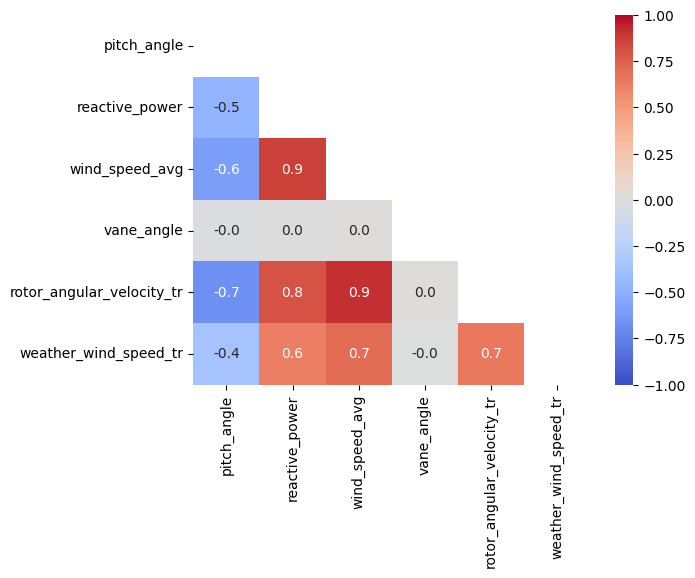

In [ ]:
# Generate correlation matrix heat map
matrix = np.triu(train_features.corr())
sns.heatmap(train_features.corr(), annot=True, fmt='.1f', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=matrix)

GridSearchCV

In [ ]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [ ]:
# Conduct search for best params while running cross-validation (GridSearchCV)
rf = RandomForestRegressor()
parameters = {
    'n_estimators': [100,150,200],
    'max_depth': [4, 8, 16]
}
cv = GridSearchCV(rf, parameters, cv=5)
cv.fit(train_features, train_labels.values.ravel())

print_results(cv)

BEST PARAMS: {'max_depth': 16, 'n_estimators': 100}

0.991 (+/-0.001) for {'max_depth': 4, 'n_estimators': 100}
0.99 (+/-0.001) for {'max_depth': 4, 'n_estimators': 150}
0.99 (+/-0.001) for {'max_depth': 4, 'n_estimators': 200}
0.996 (+/-0.0) for {'max_depth': 8, 'n_estimators': 100}
0.996 (+/-0.0) for {'max_depth': 8, 'n_estimators': 150}
0.996 (+/-0.0) for {'max_depth': 8, 'n_estimators': 200}
0.997 (+/-0.0) for {'max_depth': 16, 'n_estimators': 100}
0.997 (+/-0.0) for {'max_depth': 16, 'n_estimators': 150}
0.997 (+/-0.0) for {'max_depth': 16, 'n_estimators': 200}


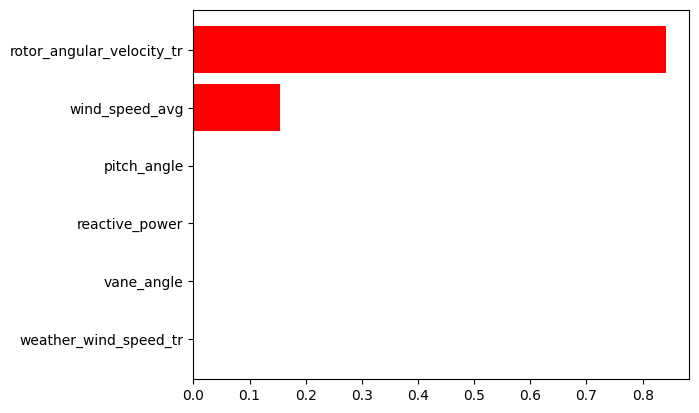

In [ ]:
# Generate feature importance plot
feat_imp = cv.best_estimator_.feature_importances_
indices = np.argsort(feat_imp)
plt.yticks(range(len(indices)), [train_features.columns[i] for i in indices])
plt.barh(range(len(indices)), feat_imp[indices], color='r', align='center')
plt.show()

In [ ]:
# Write out the model fit on the whole training set
joblib.dump(cv.best_estimator_, '/content/drive/MyDrive/WindPrediction_Extraction2/models/mdl_cleaned_original_features.pkl')

['/content/drive/MyDrive/WindPrediction_Extraction2/models/mdl_cleaned_original_features.pkl']

# Build Models To Compare Features: All Features

In [ ]:
from sklearn.model_selection import GridSearchCV
train_features = pd.read_csv('/content/drive/MyDrive/WindPrediction_Extraction2/train_features_all.csv')
train_labels = pd.read_csv('/content/drive/MyDrive/WindPrediction_Extraction2/train_labels.csv')

train_features.head()

,pitch_angle,reactive_power,nacelle_angle,nacelle_temp,wind_speed_avg,wind_angle,vane_angle,outdoor_temp,rotor_angular_velocity,rotor_bearing_temp,weather_temp,pressure,humidity,weather_wind_speed,weather_wind_angle,rain_1h,weather_wind_speed_tr,rotor_angular_velocity_tr
0,-0.497932,-0.398110,-0.104310,0.873439,0.470176,-0.080145,0.029954,0.686288,0.825376,1.014232,0.958991,-0.477611,0.772103,0.532312,0.291234,-0.242859,0.711872,0.875727
1,-0.497932,0.867141,0.490422,0.669087,0.864823,0.464293,-0.209811,0.610617,1.099771,0.957142,0.834418,-0.597979,-0.892772,1.282051,0.589328,-0.242859,1.260316,1.368780
2,-0.497932,0.147493,-1.534086,0.524468,0.600410,-1.447439,0.349490,0.195091,0.916841,0.673591,0.064210,0.485330,-0.171326,-0.170569,-1.099869,-0.242859,0.046811,1.034751
3,-0.462657,-0.899061,0.112970,-1.028611,-0.662459,0.130297,-0.010838,0.240228,-0.204053,0.401459,0.305319,-0.959081,0.494624,-0.175255,0.291234,3.316390,0.041633,-0.546707
4,1.480500,-1.025847,0.927900,0.427007,-0.958444,1.413751,0.650443,0.407501,-1.644178,-0.184672,0.538390,-0.116508,0.494624,-0.901565,-1.596691,-0.242859,-0.982341,-1.404347


<Axes: >

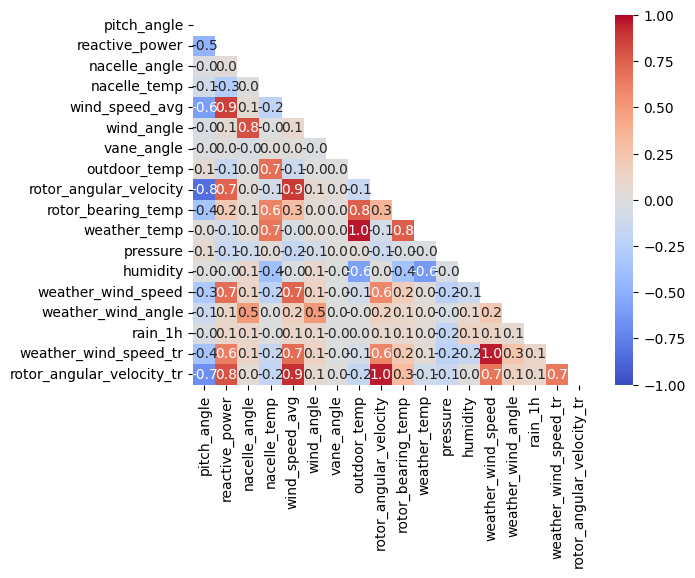

In [ ]:
# Generate correlation matrix heat map
matrix = np.triu(train_features.corr())
sns.heatmap(train_features.corr(), annot=True, fmt='.1f', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=matrix)

GridSearchCV

In [ ]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))

In [ ]:
# Conduct search for best params while running cross-validation (GridSearchCV)
rf = RandomForestRegressor()
parameters = {
    'n_estimators': [100,150],
    'max_depth': [4, 8]
}
cv = GridSearchCV(rf, parameters, cv=5)
cv.fit(train_features, train_labels.values.ravel())

print_results(cv)

BEST PARAMS: {'max_depth': 8, 'n_estimators': 150}

0.99 (+/-0.001) for {'max_depth': 4, 'n_estimators': 100}
0.99 (+/-0.001) for {'max_depth': 4, 'n_estimators': 150}
0.997 (+/-0.0) for {'max_depth': 8, 'n_estimators': 100}
0.997 (+/-0.0) for {'max_depth': 8, 'n_estimators': 150}


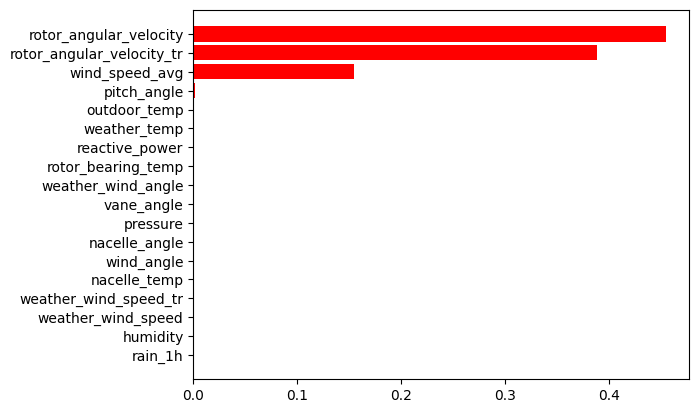

In [ ]:
# Generate feature importance plot
feat_imp = cv.best_estimator_.feature_importances_
indices = np.argsort(feat_imp)
plt.yticks(range(len(indices)), [train_features.columns[i] for i in indices])
plt.barh(range(len(indices)), feat_imp[indices], color='r', align='center')
plt.show()

In [ ]:
# Write out the model fit on the whole training set
import joblib
joblib.dump(cv.best_estimator_, '/content/drive/MyDrive/WindPrediction_Extraction2/models/mdl_all_features.pkl')

['/content/drive/MyDrive/WindPrediction_Extraction2/models/mdl_all_features.pkl']

# Build Models To Compare Features: Compare And Evaluate All Models
In this section, we will do the following:

Evaluate all of our saved models on the validation set
Select the best model based on performance on the validation set
Evaluate that model on the holdout test set

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
from time import time

val_features_raw = pd.read_csv('/content/drive/MyDrive/WindPrediction_Extraction2/val_features_raw.csv')
val_features_original = pd.read_csv('/content/drive/MyDrive/WindPrediction_Extraction2/val_features_original.csv')
val_features_all = pd.read_csv('/content/drive/MyDrive/WindPrediction_Extraction2/val_features_all.csv')


val_labels = pd.read_csv('/content/drive/MyDrive/WindPrediction_Extraction2/val_labels.csv')

val_features_raw.head()

,pitch_angle,reactive_power,wind_speed_avg,vane_angle,rotor_angular_velocity,weather_wind_speed
0,-0.497932,-0.235472,0.324157,0.032220,0.561742,0.063725
1,-0.496211,2.078940,1.247630,-0.159048,1.164334,2.476948
2,1.480500,-1.025521,-1.562253,0.191762,-1.712329,-0.901565
3,-0.497932,-0.426140,-0.015239,-0.086076,0.124144,-0.418920
4,-0.498362,0.027551,0.324157,0.002759,0.552774,0.785349


In [ ]:
# Read in models
models = {}

for mdl in ['raw_original', 'cleaned_original', 'all']:
    models[mdl] = joblib.load('/content/drive/MyDrive/WindPrediction_Extraction2/models/mdl_{}_features.pkl'.format(mdl))

**Evaluate Models On The Validation Set**

In [ ]:
def evaluate_model(name, model, features, labels):
    start = time()
    pred = model.predict(features)
    end = time()
    meanAbErr = metrics.mean_absolute_error(wind_DS_val_labels, pred)
    meanSqErr = metrics.mean_squared_error(wind_DS_val_labels, pred)
    rootMeanSqErr = np.sqrt(metrics.mean_squared_error(wind_DS_val_labels, pred))
    print('{} -- \tMAE: {} / MSE: {} / RMSE: {} / Latency: {}ms'.format(name,
                                                                                     meanAbErr,
                                                                                     meanSqErr,
                                                                                     rootMeanSqErr,
                                                                                     round((end - start)*1000, 1)))

In [ ]:
# Evaluate all of our models on the validation set
evaluate_model('Raw Features', models['raw_original'], val_features_raw, val_labels)
evaluate_model('Cleaned Features', models['cleaned_original'], val_features_original, val_labels)
evaluate_model('All Features', models['all'], val_features_all, val_labels)

Raw Features -- 	MAE: 11.673802183756473 / MSE: 642.210277638842 / RMSE: 25.34186807713358 / Latency: 2601.4ms
Cleaned Features -- 	MAE: 11.69536365481113 / MSE: 644.7848600408528 / RMSE: 25.392614281338833 / Latency: 1115.0ms
All Features -- 	MAE: 11.839367963457399 / MSE: 631.1966036476767 / RMSE: 25.12362640320216 / Latency: 497.2ms


Evaluate Best Model On Test Set

In [ ]:
# Read in our test features
test_features = pd.read_csv('/content/drive/MyDrive/WindPrediction_Extraction2/test_features_original.csv')
test_labels = pd.read_csv('/content/drive/MyDrive/WindPrediction_Extraction2/test_labels.csv')

In [ ]:
# Evaluate our final model on the test set
evaluate_model('Cleaned Features', models['cleaned_original'], test_features, test_labels)

Cleaned Features -- 	MAE: 416.56896832066894 / MSE: 363888.81326609023 / RMSE: 603.2319730137738 / Latency: 1088.3ms


In [ ]:
#Prediction of test set
#Reading test data file
test_data = pd.read_csv('/content/drive/MyDrive/test_data.csv')
#Taking only a subset of columns for test data in the dataframe
#test_data_X = test_data[['pitch_angle','reactive_power','nacelle_temp','wind_speed_avg','rotor_angular_velocity']]
test_features = test_data[['pitch_angle','reactive_power','wind_speed_avg','vane_angle','rotor_angular_velocity','weather_wind_speed']]
#Predicting the actual_power for the test data set
test_data_predict = models['raw_original'].predict(test_features)
#Predicted values for the test data set
print("Prediction of test set: {}".format(test_data_predict))

Prediction of test set: [1482.1897055  1877.78371118 1714.25349846 ... 1458.951202   1089.7665996
 1465.174257  ]
